# Mission 8 — Semantic Segmentation (U-Net): Football Scene 11-Class Segmentation

## 1) 프로젝트 개요
이번 미션의 목표는 축구 경기 장면 이미지에서 **11개 클래스 객체를 픽셀 단위로 분할(Semantic Segmentation)** 하는 모델을 학습하는 것이다.  
모델로는 대표적인 segmentation 구조인 **U-Net**을 사용하며, 한 번의 forward pass로 **(H×W) 픽셀마다 클래스(0~10)** 를 예측한다.

- 입력: 축구 경기 장면 이미지 (RGB)
- 출력: 픽셀 단위 클래스 마스크(11 classes)
- 사용 데이터: Kaggle — Football (Semantic Segmentation)
  - https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation

## 2) 데이터 & 클래스(11개)
본 데이터는 UEFA 슈퍼컵 2017 경기 하이라이트 영상에서 추출한 프레임(총 100장)으로 구성된다.  
각 이미지에는 다음 11개 클래스가 포함된다.

- Goal Bar, Referee, Advertisement, Ground, Ball  
- Coaches & Officials, Audience  
- Goalkeeper A, Goalkeeper B  
- Team A, Team B

## 3) 목표 및 평가 지표
모델 성능은 세그멘테이션에서 자주 사용하는 지표로 평가한다.

- **Cross Entropy Loss(CE)**: 픽셀 단위 다중 클래스 분류 손실
- **Dice Loss**: 클래스 불균형(특히 작은 객체)에 상대적으로 강한 overlap 기반 손실
- **mIoU(mean Intersection over Union)**: 클래스별 IoU를 평균낸 대표 성능 지표
- **mean Dice**: Dice를 평균낸 지표(정성적인 마스크 품질과도 잘 맞는 편)

> 본 노트북은  
> 데이터 로드/경로 정리 → 폴리곤 마스크 생성 → Train/Valid/Test 분할 → U-Net 학습 → 테스트 평가(mIoU/Dice) → 시각화/분석  
> 순서로 진행한다.

## 4) 재현성(실험 환경) 메모
- Random seed 고정
- 산출물(마스크/분할/모델/로그/시각화)은 `./content/football/generated` 하위로 통일 저장
- GPU 사용 가능 시 CUDA로 학습

## 0. 프로젝트 기본 세팅

이 단계에서는 **실험을 “한 번에 재현 가능하게” 만들기 위한 공통 세팅**을 수행한다.

1) 프로젝트 루트/저장 폴더 고정  
- 마스크/분할/모델/시각화/로그 산출물을 `./content/football/generated` 아래로 통일한다.

2) 재현성 세팅  
- Random seed를 고정하고, 디바이스(GPU/CPU)를 점검한다.

3) 데이터 스캔 결과 저장  
- 이후 단계에서 사용할 수 있도록 데이터/어노테이션 파일 스캔 결과를 저장한다.

> 즉, **이 단계가 끝나면 “어디에 무엇이 저장되는지”가 고정**되어 이후 실험 비교가 쉬워진다.

In [1]:
# [Code Cell] 0-1. 프로젝트 경로/출력 폴더 세팅
from pathlib import Path
import os
import json
from datetime import datetime

# 사용자 프로젝트 루트 (요청대로 ./content/football 아래에 모두 저장)
ROOT = Path("./content/football").resolve()
assert ROOT.exists(), f"[ERROR] ROOT 폴더가 없습니다: {ROOT}\n- './content/football' 경로를 다시 확인해 주세요."

# 표준 폴더 구조(생성 파일은 전부 ROOT 하위로)
DIRS = {
    "DATA": ROOT / "data",                 # 원본 데이터(선택)
    "IMAGES": ROOT / "images",             # 이미지 폴더(있다면)
    "ANNOT": ROOT / "annotations",         # json/annotation 폴더(있다면)
    "GENERATED": ROOT / "generated",       # 우리가 생성하는 모든 중간 산출물 루트
    "MASKS": ROOT / "generated" / "masks", # 폴리곤->마스크 생성 결과
    "SPLITS": ROOT / "generated" / "splits",
    "MODELS": ROOT / "generated" / "models",
    "FIGS": ROOT / "generated" / "figs",
    "LOGS": ROOT / "generated" / "logs",
    "RUNS": ROOT / "generated" / "runs",   # 실험별 폴더(타임스탬프)
}

for k, p in DIRS.items():
    p.mkdir(parents=True, exist_ok=True)

# 이번 실행(run) 폴더 하나 생성
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = DIRS["RUNS"] / RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)

print("[OK] ROOT:", ROOT)
print("[OK] RUN_DIR:", RUN_DIR)
print("\n[DIRS]")
for k, p in DIRS.items():
    print(f"- {k:9s}: {p}")

# 경로를 다른 셀에서도 쓰기 쉽게 json으로 저장(재현성/관리용)
paths_json = RUN_DIR / "paths.json"
with open(paths_json, "w", encoding="utf-8") as f:
    json.dump({k: str(v) for k, v in DIRS.items()} | {"ROOT": str(ROOT), "RUN_DIR": str(RUN_DIR)}, f, indent=2, ensure_ascii=False)

print("\n[OK] Saved:", paths_json)

[OK] ROOT: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football
[OK] RUN_DIR: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\20260126_104626

[DIRS]
- DATA     : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\data
- IMAGES   : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\images
- ANNOT    : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\annotations
- GENERATED: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated
- MASKS    : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\masks
- SPLITS   : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits
- MODELS   : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\models
- FIGS     : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\figs
- LOGS     : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\logs
- RUNS     : C:\Users\amy\Desktop\sprint\spri

In [2]:
# [Code Cell] 0-1. 프로젝트 경로/출력 폴더 세팅

from pathlib import Path
from datetime import datetime

# 1) 프로젝트 기준 루트 (현재 노트북 위치 기준)
PROJECT_ROOT = Path.cwd()

# 2) 데이터/생성물 루트
DATA_ROOT = PROJECT_ROOT / "content" / "football"
GEN_ROOT  = DATA_ROOT / "generated"

# 3) run 이름 / run 폴더
RUN_NAME = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
RUN_DIR  = GEN_ROOT / "runs" / RUN_NAME

# 4) 표준 폴더들
DIRS = {
    "DATA_ROOT": DATA_ROOT,
    "GEN_ROOT": GEN_ROOT,
    "RUN_DIR": RUN_DIR,
    "CKPTS": RUN_DIR / "ckpts",
    "LOGS":  RUN_DIR / "logs",
    "FIGS":  RUN_DIR / "figs",
    "PREDS": RUN_DIR / "preds",
    "ARTIFACTS": RUN_DIR / "artifacts",   # split/mapping 등
}

for p in DIRS.values():
    if isinstance(p, Path):
        p.mkdir(parents=True, exist_ok=True)

print("RUN_DIR:", RUN_DIR)

RUN_DIR: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626


In [3]:
# [Code Cell] 0-2. 재현성(시드) + 디바이스(GPU/CPU) 체크
import random
import numpy as np

SEED = 42

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # 재현성 우선 설정(속도 약간 희생 가능)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception as e:
        print("[WARN] torch 시드 세팅 중 예외:", e)

seed_everything(SEED)

# device 체크
try:
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[OK] SEED:", SEED)
    print("[OK] torch:", torch.__version__)
    print("[OK] device:", device)
    if device.type == "cuda":
        print("[OK] cuda name:", torch.cuda.get_device_name(0))
except Exception as e:
    print("[ERROR] torch import/device 체크 실패:", e)


[OK] SEED: 42
[OK] torch: 2.9.1+cu126
[OK] device: cuda
[OK] cuda name: NVIDIA GeForce RTX 3080


In [4]:
# [Code Cell] 0-3. 데이터 위치 스캔(이미지/어노테이션 파일 찾기) + 메타 저장
import glob

def find_candidates(root: Path):
    # 이미지 후보(대략적인 탐색)
    img_exts = ["*.jpg", "*.jpeg", "*.png"]
    image_files = []
    for ext in img_exts:
        image_files += list(root.rglob(ext))
    
    # COCO json 후보(이름에 COCO/Pixel/Football 등이 들어갈 수 있어 넓게 탐색)
    json_files = list(root.rglob("*.json"))
    
    return image_files, json_files

image_files, json_files = find_candidates(ROOT)

print(f"[SCAN] images: {len(image_files):,} files")
print(f"[SCAN] json  : {len(json_files):,} files\n")

# 상위 몇 개만 미리보기(너무 길면 보기 힘드니)
print("[Preview] image samples:")
for p in image_files[:8]:
    print(" -", p.relative_to(ROOT))

print("\n[Preview] json samples:")
for p in json_files[:8]:
    print(" -", p.relative_to(ROOT))

# COCO annotation json 후보를 "추정"해서 우선순위로 보여주기
keywords = ["coco", "football", "pixel", "annotation", "annotations"]
def score_path(p: Path):
    name = p.name.lower()
    return sum(k in name for k in keywords)

json_ranked = sorted(json_files, key=score_path, reverse=True)

print("\n[Candidate] COCO annotation json (ranked):")
for p in json_ranked[:10]:
    print(f" - score={score_path(p)} | {p.relative_to(ROOT)}")

# 스캔 결과 저장
manifest = {
    "root": str(ROOT),
    "run_dir": str(RUN_DIR),
    "num_images_found": len(image_files),
    "num_json_found": len(json_files),
    "top_json_candidates": [str(p) for p in json_ranked[:10]],
    "image_samples": [str(p) for p in image_files[:20]],
}

manifest_path = RUN_DIR / "manifest_scan.json"
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print("\n[OK] Saved scan manifest:", manifest_path)

[SCAN] images: 300 files
[SCAN] json  : 2 files

[Preview] image samples:
 - images\Frame 1  (1).jpg
 - images\Frame 1  (10).jpg
 - images\Frame 1  (100).jpg
 - images\Frame 1  (11).jpg
 - images\Frame 1  (12).jpg
 - images\Frame 1  (13).jpg
 - images\Frame 1  (14).jpg
 - images\Frame 1  (15).jpg

[Preview] json samples:
 - COCO_Football Pixel.json
 - generated\runs\20260126_104626\paths.json

[Candidate] COCO annotation json (ranked):
 - score=3 | COCO_Football Pixel.json
 - score=0 | generated\runs\20260126_104626\paths.json

[OK] Saved scan manifest: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\manifest_scan.json


## 1. 미션 개요 및 설정값 표준화

이 단계에서는 노트북 전체에서 공통으로 사용할 설정값을 **한 곳(CFG)에서 고정**하고,  
COCO JSON을 선택/로드한 뒤 “11클래스가 실제로 존재하는지”를 빠르게 점검한다.

- 설정값 예시  
  - NUM_CLASSES=11, IMG_SIZE, batch size, epoch, ignore_index(255) 등

- COCO 요약 점검  
  - images / annotations / categories 개수를 요약해 데이터 구조가 정상인지 확인한다.

- 재현성용 파일 저장  
  - 이번 실행(RUN_DIR)에 설정/요약 정보를 저장하여, 나중에 동일 조건 재실행이 가능하도록 만든다.

In [5]:
# [Code Cell] 1-1. 경로 로드 + 공통 설정(Config) 고정 및 저장
from pathlib import Path
import json

# 0번 셀에서 ROOT/RUN_DIR/DIRS가 이미 있다면 그대로 사용
# 없을 경우, 최근 RUN_DIR을 특정하기 어려우니 paths.json을 직접 지정해야 함.
try:
    ROOT, RUN_DIR, DIRS
except NameError:
    raise RuntimeError(
        "0번 셀(프로젝트 경로/출력 폴더 세팅)을 먼저 실행해 주세요. "
        "ROOT/RUN_DIR/DIRS 변수가 필요합니다."
    )

# 공통 설정값(필요 시 1곳에서만 수정)
CFG = {
    "seed": 42,
    "num_classes": 11,
    "class_names": [
        "Goal Bar",
        "Referee",
        "Advertisement",
        "Ground",
        "Ball",
        "Coaches & Officials",
        "Audience",
        "Goalkeeper A",
        "Goalkeeper B",
        "Team A",
        "Team B",
    ],
    # 초기 권장 입력 크기(이후 실험에서 바꿔도 됨)
    # 원본이 1920x1080이므로 비율을 크게 깨지지 않게 384/512 계열도 가능
    "img_size": 384,
    "train_split": 0.70,
    "valid_split": 0.15,
    "test_split": 0.15,
}

# RUN_DIR에 설정 저장
cfg_path = Path(RUN_DIR) / "config.json"
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(CFG, f, indent=2, ensure_ascii=False)

print("[OK] Saved:", cfg_path)
print(json.dumps(CFG, indent=2, ensure_ascii=False))

[OK] Saved: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\config.json
{
  "seed": 42,
  "num_classes": 11,
  "class_names": [
    "Goal Bar",
    "Referee",
    "Advertisement",
    "Ground",
    "Ball",
    "Coaches & Officials",
    "Audience",
    "Goalkeeper A",
    "Goalkeeper B",
    "Team A",
    "Team B"
  ],
  "img_size": 384,
  "train_split": 0.7,
  "valid_split": 0.15,
  "test_split": 0.15
}


In [6]:
# [Code Cell] 1-2. COCO JSON 자동 선택(스캔 결과 기반) + 경로 확정
from pathlib import Path
import json

manifest_path = Path(RUN_DIR) / "manifest_scan.json"
assert manifest_path.exists(), f"[ERROR] 스캔 결과 파일이 없습니다: {manifest_path}\n0-3 셀을 먼저 실행해 주세요."

with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

candidates = [Path(p) for p in manifest.get("top_json_candidates", [])]
candidates = [p for p in candidates if p.exists()]

assert len(candidates) > 0, (
    "[ERROR] COCO JSON 후보를 찾지 못했습니다.\n"
    "- ./content/football 아래에 .json 파일이 있는지 확인해 주세요.\n"
    "- 0-3 셀 출력의 json 후보 목록을 확인해 주세요."
)

COCO_JSON_PATH = candidates[0]  # 스캔 점수 기준 1순위 자동 선택
print("[OK] Selected COCO JSON:", COCO_JSON_PATH)

# 설정에 반영 및 저장
CFG["coco_json_path"] = str(COCO_JSON_PATH)

cfg_path = Path(RUN_DIR) / "config.json"
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(CFG, f, indent=2, ensure_ascii=False)

print("[OK] Updated:", cfg_path)

[OK] Selected COCO JSON: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\COCO_Football Pixel.json
[OK] Updated: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\config.json


In [7]:
# [Code Cell] 1-3. COCO JSON 로드 + 데이터 요약(11클래스/카테고리/어노테이션 개수 점검) + 저장
import json
from collections import Counter, defaultdict
from pathlib import Path

assert "coco_json_path" in CFG, "[ERROR] CFG에 coco_json_path가 없습니다. 1-2 셀을 먼저 실행해 주세요."
coco_path = Path(CFG["coco_json_path"])
assert coco_path.exists(), f"[ERROR] COCO JSON 파일이 없습니다: {coco_path}"

with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

# 카테고리 요약
cat_id_to_name = {c["id"]: c.get("name", str(c["id"])) for c in categories if "id" in c}
cat_ids = [c["id"] for c in categories if "id" in c]
cat_names = [cat_id_to_name[cid] for cid in cat_ids]

# 어노테이션 카운트(카테고리별)
ann_cat_ids = [a.get("category_id") for a in annotations if "category_id" in a]
ann_count_by_cat = Counter(ann_cat_ids)

# 이미지별 어노테이션 개수(간단 통계)
ann_count_by_img = Counter([a.get("image_id") for a in annotations if "image_id" in a])

summary = {
    "coco_json_path": str(coco_path),
    "num_images": len(images),
    "num_annotations": len(annotations),
    "num_categories": len(categories),
    "category_id_list": cat_ids,
    "category_name_list": cat_names,
    "annotations_per_category": {
        str(cid): {
            "name": cat_id_to_name.get(cid, str(cid)),
            "count": int(ann_count_by_cat.get(cid, 0)),
        }
        for cid in cat_ids
    },
    "annotations_per_image_stats": {
        "min": int(min(ann_count_by_img.values())) if ann_count_by_img else 0,
        "max": int(max(ann_count_by_img.values())) if ann_count_by_img else 0,
        "mean": float(sum(ann_count_by_img.values()) / max(len(ann_count_by_img), 1)),
        "num_images_with_any_annotation": int(len(ann_count_by_img)),
    },
}

# 출력(핵심만)
print("[COCO SUMMARY]")
print(" - images      :", summary["num_images"])
print(" - annotations :", summary["num_annotations"])
print(" - categories  :", summary["num_categories"])
print("\n[CATEGORIES]")
for cid in cat_ids:
    name = cat_id_to_name.get(cid, str(cid))
    cnt = ann_count_by_cat.get(cid, 0)
    print(f" - id={cid:>3} | count={cnt:>4} | name={name}")

# 11클래스 체크(과제 요구 충족 확인용)
if summary["num_categories"] != CFG["num_classes"]:
    print(
        "\n[WARN] categories 개수가 11이 아닙니다.\n"
        f" - COCO categories: {summary['num_categories']}\n"
        f" - expected       : {CFG['num_classes']}\n"
        "이 경우 categories 섹션을 확인하거나, 실제 사용할 클래스 집합을 재정의해야 합니다."
    )

# 저장
out_path = Path(RUN_DIR) / "coco_summary.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("\n[OK] Saved:", out_path)

[COCO SUMMARY]
 - images      : 100
 - annotations : 915
 - categories  : 11

[CATEGORIES]
 - id=1393250 | count=  64 | name=Goal Bar
 - id=1392807 | count=  24 | name=Referee
 - id=1392806 | count=  96 | name=Advertisements
 - id=1392805 | count=  86 | name=Ground
 - id=1392804 | count=  64 | name=Ball
 - id=1392803 | count=   0 | name=Coaches & Officials
 - id=1392802 | count=  94 | name=Audience
 - id=1392801 | count=  47 | name=Goalkeeper B
 - id=1392800 | count=  38 | name=Goalkeeper A
 - id=1392799 | count= 210 | name=Team B
 - id=1392794 | count= 192 | name=Team A

[OK] Saved: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\coco_summary.json


## 2. 데이터셋 소개

이 단계에서는 COCO JSON을 기준으로 데이터셋 구성을 정리하고,  
학습 전에 **“이미지-어노테이션 매칭이 정상인지”** 를 확인한다.

1) 데이터 개수 요약  
- 이미지 수, 어노테이션 수, 카테고리(=11클래스) 수를 정리한다.

2) 파일 존재 여부 검증  
- COCO에 기록된 `file_name`이 실제 폴더에 존재하는지 확인한다.

3) 클래스 분포 표 저장  
- 카테고리별 어노테이션 분포를 표 형태로 저장하여, 보고서/해석 근거로 활용한다.

> 세그멘테이션은 “정답 마스크가 정확히 매칭되는지”가 핵심이라, 이 단계 점검이 매우 중요하다.

In [8]:
# [Code Cell] 2-1. 프로젝트 폴더 구조 요약(상위 레벨) + COCO 기본 정보 로드
from pathlib import Path
import json

# 필수 변수 체크
try:
    ROOT, RUN_DIR, DIRS, CFG
except NameError:
    raise RuntimeError("0번/1번 셀을 먼저 실행해 주세요. (ROOT, RUN_DIR, DIRS, CFG 필요)")

coco_path = Path(CFG.get("coco_json_path", ""))
assert coco_path.exists(), f"[ERROR] COCO JSON 경로가 유효하지 않습니다: {coco_path}"

with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

print("[PROJECT ROOT]")
print(" - ROOT   :", ROOT)
print(" - RUN_DIR:", RUN_DIR)
print(" - COCO   :", coco_path)

print("\n[COCO BASIC]")
print(" - num_images      :", len(images))
print(" - num_annotations :", len(annotations))
print(" - num_categories  :", len(categories))

# 폴더 구조(상위 1~2레벨만)
def list_dir(p: Path, max_items=30):
    if not p.exists():
        return []
    items = sorted(list(p.iterdir()), key=lambda x: (x.is_file(), x.name.lower()))
    out = []
    for x in items[:max_items]:
        out.append((x.name, "dir" if x.is_dir() else "file"))
    return out

print("\n[ROOT CONTENTS] (top-level)")
for name, kind in list_dir(ROOT, max_items=50):
    print(f" - {name} ({kind})")

[PROJECT ROOT]
 - ROOT   : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football
 - RUN_DIR: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626
 - COCO   : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\COCO_Football Pixel.json

[COCO BASIC]
 - num_images      : 100
 - num_annotations : 915
 - num_categories  : 11

[ROOT CONTENTS] (top-level)
 - annotations (dir)
 - data (dir)
 - generated (dir)
 - images (dir)
 - About Acme AI.txt (file)
 - COCO_Football Pixel.json (file)
 - www.acmeai.tech ODataset 3 - Football Semantic Segmentation.pdf (file)


In [9]:
# [Code Cell] 2-2. COCO에 기록된 이미지 파일 존재 여부 검증(매칭/누락/중복) + 결과 저장
from pathlib import Path
import json
from collections import defaultdict

# images 파일명 목록
coco_filenames = [img.get("file_name") for img in images if "file_name" in img]
coco_filenames = [fn for fn in coco_filenames if isinstance(fn, str)]

assert len(coco_filenames) > 0, "[ERROR] COCO JSON의 images에 file_name이 없습니다."

# (1) 우선순위: ROOT/images 아래에서 찾기
images_dir_candidate = ROOT / "images"
search_roots = []
if images_dir_candidate.exists():
    search_roots.append(images_dir_candidate)
search_roots.append(ROOT)  # fallback: ROOT 전체 검색

# (2) 파일명(basename) -> 실제 경로 리스트 인덱스 만들기
name_to_paths = defaultdict(list)
for sr in search_roots:
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        for p in sr.rglob(ext):
            name_to_paths[p.name].append(p)

matched = {}
missing = []
ambiguous = {}

for fn in coco_filenames:
    base = Path(fn).name  # COCO file_name에 경로가 섞여 있어도 basename으로 우선 매칭
    paths = name_to_paths.get(base, [])
    if len(paths) == 0:
        missing.append(fn)
    elif len(paths) == 1:
        matched[fn] = str(paths[0])
    else:
        # 동일 파일명이 여러 위치에 있을 수 있음
        ambiguous[fn] = [str(p) for p in paths]

print("[IMAGE FILE CHECK]")
print(" - COCO filenames :", len(coco_filenames))
print(" - matched        :", len(matched))
print(" - missing        :", len(missing))
print(" - ambiguous      :", len(ambiguous))

# 결과 저장
out = {
    "coco_json_path": str(coco_path),
    "counts": {
        "coco_filenames": len(coco_filenames),
        "matched": len(matched),
        "missing": len(missing),
        "ambiguous": len(ambiguous),
    },
    "matched_map": matched,
    "missing_list": missing[:200],      # 너무 길어질 수 있어 상위만 저장(전체는 txt로 저장)
    "ambiguous_map": {k: v[:20] for k, v in list(ambiguous.items())[:200]},
}

check_path = Path(RUN_DIR) / "image_file_check.json"
with open(check_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2, ensure_ascii=False)

# missing 전체는 txt로 따로 저장
missing_txt = Path(RUN_DIR) / "missing_images.txt"
with open(missing_txt, "w", encoding="utf-8") as f:
    for x in missing:
        f.write(x + "\n")

ambiguous_json = Path(RUN_DIR) / "ambiguous_images.json"
with open(ambiguous_json, "w", encoding="utf-8") as f:
    json.dump(ambiguous, f, indent=2, ensure_ascii=False)

print("\n[OK] Saved:")
print(" -", check_path)
print(" -", missing_txt)
print(" -", ambiguous_json)

[IMAGE FILE CHECK]
 - COCO filenames : 100
 - matched        : 0
 - missing        : 0
 - ambiguous      : 100

[OK] Saved:
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\image_file_check.json
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\missing_images.txt
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\ambiguous_images.json


In [10]:
# [Code Cell] 2-3. 클래스(카테고리) 표 생성 + 어노테이션 분포 요약(저장 포함)
import pandas as pd
from collections import Counter

cat_rows = []
cat_id_to_name = {}
for c in categories:
    if "id" in c:
        cid = c["id"]
        name = c.get("name", str(cid))
        cat_id_to_name[cid] = name

ann_cat_ids = [a.get("category_id") for a in annotations if "category_id" in a]
ann_count_by_cat = Counter(ann_cat_ids)

for cid, name in cat_id_to_name.items():
    cat_rows.append({
        "category_id": cid,
        "category_name": name,
        "num_annotations": int(ann_count_by_cat.get(cid, 0)),
    })

df_cat = pd.DataFrame(cat_rows).sort_values(["num_annotations", "category_id"], ascending=[False, True]).reset_index(drop=True)

print("[CATEGORIES TABLE]")
display(df_cat)

# 저장
csv_path = Path(RUN_DIR) / "categories_table.csv"
df_cat.to_csv(csv_path, index=False, encoding="utf-8-sig")
print("\n[OK] Saved:", csv_path)

[CATEGORIES TABLE]


,category_id,category_name,num_annotations
0,1392799,Team B,210
1,1392794,Team A,192
2,1392806,Advertisements,96
3,1392802,Audience,94
4,1392805,Ground,86
5,1392804,Ball,64
6,1393250,Goal Bar,64
7,1392801,Goalkeeper B,47
8,1392800,Goalkeeper A,38
9,1392807,Referee,24



[OK] Saved: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\categories_table.csv


In [11]:
# [Code Cell] 2-4. 이미지 해상도/메타 정보 샘플 확인(실제 파일 기준, 가능하면)
from PIL import Image

# 2-2에서 matched_map 저장했으니 다시 로드해서 사용
import json
from pathlib import Path

check_path = Path(RUN_DIR) / "image_file_check.json"
with open(check_path, "r", encoding="utf-8") as f:
    chk = json.load(f)

matched_map = chk.get("matched_map", {})
sample_items = list(matched_map.items())[:5]

if len(sample_items) == 0:
    print("[INFO] 매칭된 이미지가 없어 샘플 확인을 건너뜁니다. (2-2 결과에서 missing/ambiguous 확인)")
else:
    print("[IMAGE META SAMPLES]")
    for coco_fn, real_path in sample_items:
        p = Path(real_path)
        with Image.open(p) as im:
            w, h = im.size
        print(f" - {coco_fn} -> {p.name} | size={w}x{h}")

[INFO] 매칭된 이미지가 없어 샘플 확인을 건너뜁니다. (2-2 결과에서 missing/ambiguous 확인)


2-추가. 이미지 경로 문제 해결

이 단계에서는 COCO JSON의 `file_name`과 실제 이미지 파일 경로가 어긋나는 문제를 해결한다.

- `./content/football` 하위에서 이미지가 실제로 존재하는 위치를 자동 탐색한다.
- 공백/대소문자 등 파일명 차이를 흡수하도록 정규화하여 매칭한다.
- 최종 매칭 결과를 저장해 이후 단계(마스크 생성/학습/시각화)가 **항상 동일 기준**으로 진행되게 한다.

> “경로 문제”를 초기에 해결해두면, 이후 실험에서 데이터 로딩 오류로 시간을 날리는 일을 크게 줄일 수 있다.

In [12]:
# [Code Cell] 2-5. 이미지 폴더 자동 탐색(어디에 jpg/png가 있는지) + 후보 디렉터리 요약
from pathlib import Path
from collections import Counter

try:
    ROOT, RUN_DIR, DIRS, CFG, coco, images
except NameError:
    raise RuntimeError("0~2번 셀을 먼저 실행해 주세요. (ROOT/RUN_DIR/CFG/coco/images 필요)")

# 대소문자 확장자까지 포함해서 탐색
img_patterns = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]

all_imgs = []
for pat in img_patterns:
    all_imgs.extend(list(Path(ROOT).rglob(pat)))

print("[SCAN] total image files found under ROOT:", len(all_imgs))

# 상위 폴더별로 몇 장 있는지 요약(깊이 2~3 정도로 보기)
parent_counter = Counter()
for p in all_imgs:
    # ROOT 기준 상대경로에서 상위 2단계까지를 묶어서 집계
    rel = p.relative_to(ROOT)
    parts = rel.parts
    key = "/".join(parts[:2]) if len(parts) >= 2 else parts[0]
    parent_counter[key] += 1

print("\n[TOP IMAGE DIR CANDIDATES] (by count)")
for k, v in parent_counter.most_common(15):
    print(f" - {k:40s} : {v}")

# 가장 많은 이미지가 있는 경로를 기본 후보로 선택(필요시 사용자가 바꿀 수 있음)
if len(all_imgs) == 0:
    print("\n[WARN] ROOT 아래에서 이미지 파일을 찾지 못했습니다.")
else:
    top_key, top_cnt = parent_counter.most_common(1)[0]
    guessed_dir = Path(ROOT) / top_key
    print("\n[GUESS] images_dir candidate:", guessed_dir, f"(count={top_cnt})")

    # CFG에 저장(이후 셀에서 사용)
    CFG["images_dir_guess"] = str(guessed_dir)

    # 저장
    import json
    cfg_path = Path(RUN_DIR) / "config.json"
    with open(cfg_path, "w", encoding="utf-8") as f:
        json.dump(CFG, f, indent=2, ensure_ascii=False)
    print("[OK] Updated:", cfg_path)

[SCAN] total image files found under ROOT: 600

[TOP IMAGE DIR CANDIDATES] (by count)
 - images/Frame 1  (1).jpg                  : 2
 - images/Frame 1  (10).jpg                 : 2
 - images/Frame 1  (100).jpg                : 2
 - images/Frame 1  (11).jpg                 : 2
 - images/Frame 1  (12).jpg                 : 2
 - images/Frame 1  (13).jpg                 : 2
 - images/Frame 1  (14).jpg                 : 2
 - images/Frame 1  (15).jpg                 : 2
 - images/Frame 1  (16).jpg                 : 2
 - images/Frame 1  (17).jpg                 : 2
 - images/Frame 1  (18).jpg                 : 2
 - images/Frame 1  (19).jpg                 : 2
 - images/Frame 1  (2).jpg                  : 2
 - images/Frame 1  (20).jpg                 : 2
 - images/Frame 1  (21).jpg                 : 2

[GUESS] images_dir candidate: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\images\Frame 1  (1).jpg (count=2)
[OK] Updated: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\foot

2-추가. ambiguous=100 문제 해결(중복 제거 + 자동 선택 규칙)

이 단계에서는 COCO의 `file_name` 하나가 **여러 실제 파일 경로로 매칭되는(ambiguous)** 문제를 해결한다.

1) 동일 경로 중복 제거  
2) 후보가 여러 개면, “추정한 이미지 폴더(images_dir_guess) 하위”를 우선 선택  
3) 그래도 여러 개면, ROOT 기준 상대경로가 더 짧은(가까운) 경로를 선택

- 최종 선택 결과를 `image_file_check_v3.json`으로 저장한다.

> 중복/ambiguous 문제를 해결하지 않으면, 같은 file_name이 실행할 때마다 다른 파일을 가리켜 **재현성이 깨질 수** 있다.

In [13]:
# [Code Cell] 2-8. ambiguous 해결: 경로 중복 제거 + 자동 선택(우선순위 규칙) + v3 저장
from pathlib import Path
import re
import json
from collections import defaultdict

try:
    ROOT, RUN_DIR, CFG, images
except NameError:
    raise RuntimeError("0~2번 셀을 먼저 실행해 주세요. (ROOT/RUN_DIR/CFG/images 필요)")

# COCO 파일명
coco_filenames = [img.get("file_name") for img in images if "file_name" in img]
coco_filenames = [fn for fn in coco_filenames if isinstance(fn, str)]
assert len(coco_filenames) == 100, f"[WARN] COCO filenames가 100이 아닙니다: {len(coco_filenames)}"

# 정규화 함수(2-6과 동일)
def norm_name(s: str) -> str:
    s = Path(s).name
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

# 이미지 후보 파일 수집: ROOT 전체에서 한 번만 스캔(중복 스캔 원천 차단)
img_patterns = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
all_paths = []
for pat in img_patterns:
    all_paths.extend(list(Path(ROOT).rglob(pat)))

# 정규화 basename -> "유니크 경로 set"로 저장
name_to_paths = defaultdict(set)
for p in all_paths:
    name_to_paths[norm_name(p.name)].add(str(p.resolve()))

# 후보 다중일 때 선택 규칙
images_dir_guess = Path(CFG.get("images_dir_guess", ROOT)).resolve()
def pick_best(paths):
    # paths: list[str] (resolved absolute)
    # 1) images_dir_guess 하위 경로 우선
    under_guess = [p for p in paths if str(p).startswith(str(images_dir_guess))]
    candidates = under_guess if len(under_guess) > 0 else paths
    
    # 2) ROOT 기준 상대경로가 짧은 것(가까운 폴더) 우선
    def score(p):
        try:
            rel = Path(p).resolve().relative_to(Path(ROOT).resolve())
            return (len(rel.parts), len(str(rel)))  # 폴더 깊이, 문자열 길이
        except Exception:
            return (10**9, 10**9)
    candidates = sorted(candidates, key=score)
    return candidates[0], candidates

resolved = {}
still_ambiguous = {}
missing = []

for fn in coco_filenames:
    key = norm_name(fn)
    paths = sorted(list(name_to_paths.get(key, set())))
    if len(paths) == 0:
        missing.append(fn)
    elif len(paths) == 1:
        resolved[fn] = paths[0]
    else:
        best, candidates_sorted = pick_best(paths)
        resolved[fn] = best
        # 참고용으로 기록(실제 후보가 여러 개였던 애들)
        still_ambiguous[fn] = candidates_sorted[:20]

print("[IMAGE MATCH RESULT - RESOLVED(v3)]")
print(" - COCO filenames :", len(coco_filenames))
print(" - resolved       :", len(resolved))
print(" - missing        :", len(missing))
print(" - had_multi_paths:", len(still_ambiguous))

# 저장
out = {
    "coco_json_path": str(CFG.get("coco_json_path", "")),
    "images_dir_guess": str(images_dir_guess),
    "counts": {
        "coco_filenames": len(coco_filenames),
        "resolved": len(resolved),
        "missing": len(missing),
        "had_multi_paths": len(still_ambiguous),
    },
    "resolved_map": resolved,
    "missing_list": missing,
    "multi_path_examples": dict(list(still_ambiguous.items())[:50]),  # 예시만 저장
}

check_path = Path(RUN_DIR) / "image_file_check_v3.json"
with open(check_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2, ensure_ascii=False)

# 멀티경로 전체는 별도 저장(필요시 확인)
multi_path_full = Path(RUN_DIR) / "image_multi_paths_full.json"
with open(multi_path_full, "w", encoding="utf-8") as f:
    json.dump(still_ambiguous, f, indent=2, ensure_ascii=False)

print("\n[OK] Saved:")
print(" -", check_path)
print(" -", multi_path_full)

[IMAGE MATCH RESULT - RESOLVED(v3)]
 - COCO filenames : 100
 - resolved       : 100
 - missing        : 0
 - had_multi_paths: 0

[OK] Saved:
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\image_file_check_v3.json
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\image_multi_paths_full.json


In [14]:
# [Code Cell] 2-9. resolved 결과로 이미지 샘플 5장 메타 확인(열어서 size 체크)
from pathlib import Path
import json
from PIL import Image

check_path = Path(RUN_DIR) / "image_file_check_v3.json"
assert check_path.exists(), f"[ERROR] {check_path} 가 없습니다. 2-8을 먼저 실행해 주세요."

with open(check_path, "r", encoding="utf-8") as f:
    chk = json.load(f)

resolved_map = chk.get("resolved_map", {})
items = list(resolved_map.items())[:5]

if len(items) == 0:
    print("[WARN] resolved_map이 비어있습니다. 2-8 출력부터 확인해 주세요.")
else:
    for coco_fn, real_path in items:
        p = Path(real_path)
        with Image.open(p) as im:
            w, h = im.size
        print(f" - {coco_fn} -> {p.name} | size={w}x{h}")

 - Frame 1  (14).jpg -> Frame 1  (14).jpg | size=1920x1080
 - Frame 1  (12).jpg -> Frame 1  (12).jpg | size=1920x1080
 - Frame 1  (18).jpg -> Frame 1  (18).jpg | size=1920x1080
 - Frame 1  (20).jpg -> Frame 1  (20).jpg | size=1920x1080
 - Frame 1  (22).jpg -> Frame 1  (22).jpg | size=1920x1080


## 3. 클래스 매핑표 확정

이 단계에서는 COCO의 `category_id`를 학습용 `train_id(0~10)`으로 연속 매핑하고,  
시각화/학습에서 사용할 공통 규칙을 확정한다.

- `category_id → train_id(0~10)` 매핑 생성  
  - 모델 출력 채널(11개)이 0~10으로 고정되어 loss/metric 계산이 안정적이다.

- 클래스 팔레트(RGB) 확정  
  - GT/Pred 시각화에서 항상 동일한 색으로 표시되어 해석이 쉬워진다.

- `image_id ↔ 실제 이미지 경로` 인덱스 생성  
  - 다음 단계(폴리곤→마스크 생성)에서 재사용한다.

In [15]:
# [Code Cell] 3-1. COCO 로드 + categories/annotations 기본 테이블 생성
from pathlib import Path
import json
import pandas as pd
import re
from collections import Counter

# 필수 변수 확인
try:
    ROOT, RUN_DIR, DIRS, CFG
except NameError:
    raise RuntimeError("0~2번 셀을 먼저 실행해 주세요. (ROOT/RUN_DIR/DIRS/CFG 필요)")

coco_path = Path(CFG.get("coco_json_path", ""))
assert coco_path.exists(), f"[ERROR] COCO JSON 경로가 유효하지 않습니다: {coco_path}"

with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

assert len(categories) == 11, f"[ERROR] categories 개수가 11이 아닙니다: {len(categories)}"

# category별 annotation count
ann_cat_ids = [a.get("category_id") for a in annotations if "category_id" in a]
ann_count_by_cat = Counter(ann_cat_ids)

df_cat = pd.DataFrame([{
    "category_id": c["id"],
    "category_name": c.get("name", str(c["id"])),
    "num_annotations": int(ann_count_by_cat.get(c["id"], 0))
} for c in categories]).sort_values(["num_annotations", "category_id"], ascending=[False, True]).reset_index(drop=True)

print("[CATEGORIES RAW]")
display(df_cat)

[CATEGORIES RAW]


,category_id,category_name,num_annotations
0,1392799,Team B,210
1,1392794,Team A,192
2,1392806,Advertisements,96
3,1392802,Audience,94
4,1392805,Ground,86
5,1392804,Ball,64
6,1393250,Goal Bar,64
7,1392801,Goalkeeper B,47
8,1392800,Goalkeeper A,38
9,1392807,Referee,24


In [16]:
# [Code Cell] 3-2. category_name 정규화 + 표준 11클래스 순서에 맞춰 train_id(0~10) 부여
# 표준 클래스 순서(보고서/학습/시각화 공통 기준)
CANONICAL = [
    "Goal Bar",
    "Referee",
    "Advertisement",
    "Ground",
    "Ball",
    "Coaches & Officials",
    "Audience",
    "Goalkeeper A",
    "Goalkeeper B",
    "Team A",
    "Team B",
]

def norm_text(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("&", "and")
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]", "", s)  # 특수문자 제거(공백/영문/숫자만)
    return s

# 데이터셋에서 자주 나오는 표기 변형을 흡수하는 alias 테이블
ALIASES = {
    "goal bar": "Goal Bar",
    "goalbar": "Goal Bar",

    "referee": "Referee",

    "advertisement": "Advertisement",
    "advertisements": "Advertisement",

    "ground": "Ground",
    "grass": "Ground",

    "ball": "Ball",

    "coaches officials": "Coaches & Officials",
    "coaches and officials": "Coaches & Officials",
    "coaches officials staff": "Coaches & Officials",

    "audience": "Audience",
    "crowd": "Audience",

    "goalkeeper a": "Goalkeeper A",
    "goalkeepera": "Goalkeeper A",
    "gk a": "Goalkeeper A",

    "goalkeeper b": "Goalkeeper B",
    "goalkeeperb": "Goalkeeper B",
    "gk b": "Goalkeeper B",

    "team a": "Team A",
    "teama": "Team A",

    "team b": "Team B",
    "teamb": "Team B",
}

canonical_set = set(CANONICAL)
order_map = {name: i for i, name in enumerate(CANONICAL)}

def map_to_canonical(name: str) -> str:
    key = norm_text(name)
    # 완전 매칭 alias
    if key in ALIASES:
        return ALIASES[key]
    # 부분 포함(안전한 범위만)
    if "advertis" in key:
        return "Advertisement"
    if "goal bar" in key or "goalbar" in key:
        return "Goal Bar"
    if "goalkeeper" in key and " a" in (" " + key + " "):
        return "Goalkeeper A"
    if "goalkeeper" in key and " b" in (" " + key + " "):
        return "Goalkeeper B"
    if "team a" in key:
        return "Team A"
    if "team b" in key:
        return "Team B"
    if "coach" in key and "official" in key:
        return "Coaches & Officials"
    # 마지막 fallback: 원문이 canonical과 동일한 경우(대소문자 차이 등)
    for c in CANONICAL:
        if norm_text(c) == key:
            return c
    return "__UNMAPPED__"

df_map = df_cat.copy()
df_map["canonical_name"] = df_map["category_name"].apply(map_to_canonical)

unmapped = df_map[df_map["canonical_name"] == "__UNMAPPED__"]
assert len(unmapped) == 0, (
    "[ERROR] canonical_name 매핑 실패가 있습니다.\n"
    "아래 출력(df)에서 '__UNMAPPED__' rows를 확인해 주세요.\n"
)

# canonical 기준으로 정렬
df_map["canonical_order"] = df_map["canonical_name"].map(order_map)
df_map = df_map.sort_values(["canonical_order", "category_id"]).reset_index(drop=True)

# canonical 순서대로 train_id 부여(0~10)
# 같은 canonical이 2개 이상 나오는 경우는 데이터가 이상한 것이므로 검사
dup = df_map["canonical_name"].duplicated().any()
assert not dup, "[ERROR] 동일 canonical_name이 2개 이상입니다. categories 이름이 중복일 수 있어요."

df_map["train_id"] = range(len(df_map))

print("[CLASS MAPPING TABLE]")
display(df_map[["train_id", "canonical_name", "category_id", "category_name", "num_annotations"]])

# Coaches & Officials 0개 여부 메모(보고서에 쓸 근거로 남김)
co_row = df_map[df_map["canonical_name"] == "Coaches & Officials"]
if len(co_row) == 1 and int(co_row["num_annotations"].iloc[0]) == 0:
    print("[NOTE] 'Coaches & Officials' 클래스는 annotation이 0개입니다. (보고서에 데이터 한계로 명시 권장)")


[CLASS MAPPING TABLE]


,train_id,canonical_name,category_id,category_name,num_annotations
0,0,Goal Bar,1393250,Goal Bar,64
1,1,Referee,1392807,Referee,24
2,2,Advertisement,1392806,Advertisements,96
3,3,Ground,1392805,Ground,86
4,4,Ball,1392804,Ball,64
5,5,Coaches & Officials,1392803,Coaches & Officials,0
6,6,Audience,1392802,Audience,94
7,7,Goalkeeper A,1392800,Goalkeeper A,38
8,8,Goalkeeper B,1392801,Goalkeeper B,47
9,9,Team A,1392794,Team A,192


[NOTE] 'Coaches & Officials' 클래스는 annotation이 0개입니다. (보고서에 데이터 한계로 명시 권장)


In [17]:
# [Code Cell] 3-3. 고정 팔레트(RGB) 확정 + class_mapping.json / table.csv 저장
from pathlib import Path
import json

# 고정 팔레트(시각화 전용). 이후 GT/Pred 디코딩에 항상 동일하게 사용.
PALETTE = {
    0: [255,   0,   0],   # Goal Bar
    1: [  0, 255, 255],   # Referee
    2: [255, 255,   0],   # Advertisement
    3: [  0, 180,   0],   # Ground
    4: [255,   0, 255],   # Ball
    5: [128,   0, 128],   # Coaches & Officials
    6: [255, 165,   0],   # Audience
    7: [  0,   0, 139],   # Goalkeeper A
    8: [139,  69,  19],   # Goalkeeper B
    9: [  0,   0, 255],   # Team A
    10:[255, 105, 180],   # Team B
}

# mapping dict 구성
category_id_to_train_id = {int(r["category_id"]): int(r["train_id"]) for _, r in df_map.iterrows()}
train_id_to_category_id = {int(r["train_id"]): int(r["category_id"]) for _, r in df_map.iterrows()}
train_id_to_name = {int(r["train_id"]): str(r["canonical_name"]) for _, r in df_map.iterrows()}
train_id_to_orig_name = {int(r["train_id"]): str(r["category_name"]) for _, r in df_map.iterrows()}
train_id_to_ann_count = {int(r["train_id"]): int(r["num_annotations"]) for _, r in df_map.iterrows()}

class_mapping = {
    "num_classes": 11,
    "train_id_order": [train_id_to_name[i] for i in range(11)],
    "category_id_to_train_id": category_id_to_train_id,
    "train_id_to_category_id": train_id_to_category_id,
    "train_id_to_name": train_id_to_name,
    "train_id_to_original_category_name": train_id_to_orig_name,
    "train_id_to_num_annotations": train_id_to_ann_count,
    "palette_rgb": {str(k): v for k, v in PALETTE.items()},
    "notes": [
        "train_id는 0~10 연속 인덱스입니다.",
        "palette_rgb는 시각화용 고정 색상입니다.",
        "Coaches & Officials는 annotation이 0개일 수 있으며, 이 경우 보고서에 데이터 한계로 명시합니다.",
    ],
}

# 저장 경로
map_json_path = Path(RUN_DIR) / "class_mapping.json"
map_csv_path = Path(RUN_DIR) / "class_mapping_table.csv"

with open(map_json_path, "w", encoding="utf-8") as f:
    json.dump(class_mapping, f, indent=2, ensure_ascii=False)

df_out = df_map.copy()
df_out["palette_rgb"] = df_out["train_id"].apply(lambda i: PALETTE[int(i)])
df_out.to_csv(map_csv_path, index=False, encoding="utf-8-sig")

print("[OK] Saved:")
print(" -", map_json_path)
print(" -", map_csv_path)

print("\n[MAPPING PREVIEW]")
display(df_out[["train_id", "canonical_name", "category_id", "category_name", "num_annotations", "palette_rgb"]])

[OK] Saved:
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\class_mapping.json
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\class_mapping_table.csv

[MAPPING PREVIEW]


,train_id,canonical_name,category_id,category_name,num_annotations,palette_rgb
0,0,Goal Bar,1393250,Goal Bar,64,"[255, 0, 0]"
1,1,Referee,1392807,Referee,24,"[0, 255, 255]"
2,2,Advertisement,1392806,Advertisements,96,"[255, 255, 0]"
3,3,Ground,1392805,Ground,86,"[0, 180, 0]"
4,4,Ball,1392804,Ball,64,"[255, 0, 255]"
5,5,Coaches & Officials,1392803,Coaches & Officials,0,"[128, 0, 128]"
6,6,Audience,1392802,Audience,94,"[255, 165, 0]"
7,7,Goalkeeper A,1392800,Goalkeeper A,38,"[0, 0, 139]"
8,8,Goalkeeper B,1392801,Goalkeeper B,47,"[139, 69, 19]"
9,9,Team A,1392794,Team A,192,"[0, 0, 255]"


In [18]:
# [Code Cell] 3-4. image_id -> 실제 파일 경로 인덱스 생성(image_index.json) 저장
from pathlib import Path
import json

# 2-8에서 만든 resolved_map 로드
check_v3 = Path(RUN_DIR) / "image_file_check_v3.json"
assert check_v3.exists(), f"[ERROR] {check_v3} 가 없습니다. 2-8을 먼저 실행해 주세요."

with open(check_v3, "r", encoding="utf-8") as f:
    chk = json.load(f)

resolved_map = chk.get("resolved_map", {})
assert len(resolved_map) == 100, f"[WARN] resolved_map 크기가 100이 아닙니다: {len(resolved_map)}"

# file_name -> path 매핑 (COCO file_name을 키로 사용)
fn_to_path = {k: v for k, v in resolved_map.items()}

image_index = {}
missing_paths = []

for img in images:
    img_id = img["id"]
    fn = img.get("file_name")
    if fn not in fn_to_path:
        missing_paths.append(fn)
        continue
    image_index[str(img_id)] = {
        "image_id": img_id,
        "file_name": fn,
        "path": fn_to_path[fn],
        "width": img.get("width"),
        "height": img.get("height"),
    }

print("[IMAGE INDEX]")
print(" - total images in COCO :", len(images))
print(" - indexed images       :", len(image_index))
print(" - missing paths        :", len(missing_paths))

idx_path = Path(RUN_DIR) / "image_index.json"
with open(idx_path, "w", encoding="utf-8") as f:
    json.dump(image_index, f, indent=2, ensure_ascii=False)

missing_path_txt = Path(RUN_DIR) / "image_index_missing.txt"
with open(missing_path_txt, "w", encoding="utf-8") as f:
    for x in missing_paths:
        f.write(str(x) + "\n")

print("[OK] Saved:")
print(" -", idx_path)
print(" -", missing_path_txt)

# 샘플 3개만 출력
sample_keys = list(image_index.keys())[:3]
for k in sample_keys:
    v = image_index[k]
    print(f" - image_id={v['image_id']} | {Path(v['path']).name} | {v['width']}x{v['height']}")

[IMAGE INDEX]
 - total images in COCO : 100
 - indexed images       : 100
 - missing paths        : 0
[OK] Saved:
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\image_index.json
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\image_index_missing.txt
 - image_id=1 | Frame 1  (14).jpg | 1920x1080
 - image_id=2 | Frame 1  (12).jpg | 1920x1080
 - image_id=3 | Frame 1  (18).jpg | 1920x1080


## 4. 폴리곤 → 픽셀 마스크 생성 및 GT 검증 시각화

이 단계에서는 COCO의 polygon annotation(`segmentation`)을 이용해  
각 이미지의 **픽셀 단위 GT 마스크(0~10)** 를 생성하고, 샘플 시각화로 품질을 검증한다.

1) 폴리곤 rasterize → 마스크 생성  
- 각 픽셀에 클래스(train_id)를 할당한다.

2) IGNORE 영역 처리  
- 라벨이 없는 픽셀은 `IGNORE=255`로 남겨 손실 계산에서 제외 가능하게 한다.

3) GT 검증 시각화  
- 컬러 마스크/오버레이로 샘플을 확인해 “클래스 매핑/경계/누락”이 정상인지 점검한다.

> 세그멘테이션은 GT 마스크가 곧 정답이므로, 이 단계에서의 시각 검증이 필수다.

In [19]:
# [Code Cell] 4-1. 입력( COCO / 매핑 / 이미지 인덱스 ) 로드 + 출력 폴더 확정
from pathlib import Path
import json
import re

try:
    ROOT, RUN_DIR, DIRS, CFG
except NameError:
    raise RuntimeError("0~3번 셀을 먼저 실행해 주세요. (ROOT/RUN_DIR/DIRS/CFG 필요)")

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# COCO
coco_path = Path(CFG["coco_json_path"])
assert coco_path.exists(), f"[ERROR] COCO JSON이 없습니다: {coco_path}"
with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

# class mapping
map_path = RUN_DIR / "class_mapping.json"
assert map_path.exists(), f"[ERROR] class_mapping.json이 없습니다: {map_path} (3-3 셀 실행 필요)"
with open(map_path, "r", encoding="utf-8") as f:
    class_map = json.load(f)

cat2tid = {int(k): int(v) for k, v in class_map["category_id_to_train_id"].items()}
tid2name = {int(k): v for k, v in class_map["train_id_to_name"].items()}
palette = {int(k): v for k, v in class_map["palette_rgb"].items()}

# image index (image_id -> real path)
idx_path = RUN_DIR / "image_index.json"
assert idx_path.exists(), f"[ERROR] image_index.json이 없습니다: {idx_path} (3-4 셀 실행 필요)"
with open(idx_path, "r", encoding="utf-8") as f:
    image_index = json.load(f)

def _ensure_run_subdir(root_path: Path, run_name: str) -> Path:
    root_path = Path(root_path)
    # 이미 RUN_DIR 안쪽이거나, 이미 run_name으로 끝나면 그대로 사용
    try:
        if root_path.is_relative_to(RUN_DIR) or root_path.name == run_name:
            return root_path
    except Exception:
        if str(RUN_DIR) in str(root_path) or root_path.name == run_name:
            return root_path
    return root_path / run_name

# masks/figs output: DIRS 기준 (run 중복 생성 방지)
MASKS_BASE = Path(DIRS["MASKS"]) if "MASKS" in DIRS else (RUN_DIR / "masks")
FIGS_BASE  = Path(DIRS["FIGS"])  if "FIGS"  in DIRS else (RUN_DIR / "figs")

MASKS_OUT_DIR = _ensure_run_subdir(MASKS_BASE, RUN_NAME)
FIGS_OUT_DIR  = _ensure_run_subdir(FIGS_BASE, RUN_NAME)

MASKS_OUT_DIR.mkdir(parents=True, exist_ok=True)
FIGS_OUT_DIR.mkdir(parents=True, exist_ok=True)

IGNORE_LABEL = 255

print("[OK] COCO:", coco_path)
print("[OK] mapping:", map_path)
print("[OK] image_index:", idx_path)
print("[OK] MASKS_OUT_DIR:", MASKS_OUT_DIR)
print("[OK] FIGS_OUT_DIR :", FIGS_OUT_DIR)
print("[OK] IGNORE_LABEL :", IGNORE_LABEL)

[OK] COCO: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\COCO_Football Pixel.json
[OK] mapping: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\class_mapping.json
[OK] image_index: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\image_index.json
[OK] MASKS_OUT_DIR: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\masks
[OK] FIGS_OUT_DIR : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\figs
[OK] IGNORE_LABEL : 255


In [20]:
# [Code Cell] 4-2. 폴리곤 래스터라이즈(마스크화) 유틸 + 우선순위 규칙 정의
from PIL import Image, ImageDraw
import numpy as np
from collections import defaultdict

# annotations를 image_id 기준으로 묶기
ann_by_img = defaultdict(list)
for a in annotations:
    if "image_id" in a:
        ann_by_img[int(a["image_id"])].append(a)

# 우선순위(낮은 것부터 먼저 칠하고, 높은 것(중요/작은 것)을 마지막에 덮어쓰기)
# train_id 기준: Ground(3) 가장 아래, Ball(4) 가장 위로 권장
PRIORITY_TRAIN_IDS = [
    3,  # Ground
    6,  # Audience
    2,  # Advertisement
    5,  # Coaches & Officials
    9,  # Team A
    10, # Team B
    7,  # Goalkeeper A
    8,  # Goalkeeper B
    1,  # Referee
    0,  # Goal Bar
    4,  # Ball
]
priority_rank = {tid: i for i, tid in enumerate(PRIORITY_TRAIN_IDS)}

def polygon_to_binary_mask(segmentation, h: int, w: int) -> np.ndarray:
    """
    segmentation: COCO polygon format (list of polygons).
      - 일반적으로: [[x1,y1,x2,y2,...], [x1,y1,...], ...]
    return: (h,w) binary mask (uint8: 0/1)
    """
    if not isinstance(segmentation, list):
        raise ValueError(f"Unsupported segmentation type (expected list polygons): {type(segmentation)}")

    canvas = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(canvas)

    # segmentation은 polygon list의 list인 경우가 많음
    polys = segmentation
    # 어떤 경우는 segmentation이 [x1,y1,...] 1차원으로 올 수도 있어 방어
    if len(polys) > 0 and isinstance(polys[0], (int, float)):
        polys = [polys]

    for poly in polys:
        if not isinstance(poly, list) or len(poly) < 6:
            continue
        xy = [(poly[i], poly[i + 1]) for i in range(0, len(poly) - 1, 2)]
        draw.polygon(xy, outline=1, fill=1)

    return np.array(canvas, dtype=np.uint8)

def build_gt_mask_for_image(image_id: int) -> np.ndarray:
    """
    image_id에 해당하는 GT 마스크 생성.
    - 초기값: IGNORE_LABEL
    - annotation 폴리곤을 우선순위 순서대로 덮어쓰기
    """
    meta = image_index.get(str(image_id))
    if meta is None:
        raise KeyError(f"image_index에 image_id={image_id}가 없습니다.")

    h = int(meta["height"])
    w = int(meta["width"])

    # IGNORE로 초기화
    gt = np.full((h, w), IGNORE_LABEL, dtype=np.uint8)

    anns = ann_by_img.get(int(image_id), [])
    if len(anns) == 0:
        return gt

    # 각 annotation에 train_id 부여 + 우선순위 정렬
    enriched = []
    for a in anns:
        cid = a.get("category_id")
        if cid is None:
            continue
        cid = int(cid)
        if cid not in cat2tid:
            continue
        tid = int(cat2tid[cid])
        enriched.append((priority_rank.get(tid, 999), tid, a))

    enriched.sort(key=lambda x: x[0])  # 낮은 우선순위부터

    for _, tid, a in enriched:
        seg = a.get("segmentation")
        if seg is None:
            continue

        # polygon만 지원(현재 데이터는 polygon 형태)
        # dict(RLE) 형태면 pycocotools가 필요하니 여기서는 에러로 알림
        if isinstance(seg, dict):
            raise ValueError(
                "segmentation이 RLE(dict) 형태입니다. 이 경우 pycocotools 기반 디코딩이 필요합니다."
            )

        bin_mask = polygon_to_binary_mask(seg, h, w)
        gt[bin_mask == 1] = tid

    return gt

def mask_to_color(mask: np.ndarray) -> np.ndarray:
    """(H,W) label mask -> (H,W,3) RGB"""
    h, w = mask.shape
    out = np.zeros((h, w, 3), dtype=np.uint8)
    for tid, rgb in palette.items():
        out[mask == tid] = np.array(rgb, dtype=np.uint8)
    # IGNORE는 검정(0,0,0) 유지
    return out

print("[OK] Utils ready. annotations grouped:", len(ann_by_img))
print("[OK] Priority order:", [(tid, tid2name.get(tid, str(tid))) for tid in PRIORITY_TRAIN_IDS])

[OK] Utils ready. annotations grouped: 100
[OK] Priority order: [(3, 'Ground'), (6, 'Audience'), (2, 'Advertisement'), (5, 'Coaches & Officials'), (9, 'Team A'), (10, 'Team B'), (7, 'Goalkeeper A'), (8, 'Goalkeeper B'), (1, 'Referee'), (0, 'Goal Bar'), (4, 'Ball')]


In [21]:
# [Code Cell] 4-3. 전체 이미지 GT 마스크 생성 + 저장(mask_index.json 생성)
from pathlib import Path
import numpy as np
from PIL import Image
import json

def safe_stem(file_name: str) -> str:
    stem = Path(file_name).stem
    stem = re.sub(r"[^a-zA-Z0-9_\-]+", "_", stem).strip("_")
    return stem[:80] if len(stem) > 80 else stem

mask_index = {}
stats = {
    "num_images": 0,
    "num_masks_saved": 0,
    "num_errors": 0,
    "ignore_pixel_ratio_mean": None,
}

ignore_ratios = []
errors = []

for img in images:
    image_id = int(img["id"])
    file_name = img.get("file_name", f"img_{image_id}")
    meta = image_index.get(str(image_id))
    if meta is None:
        errors.append({"image_id": image_id, "error": "missing_in_image_index"})
        continue

    try:
        gt = build_gt_mask_for_image(image_id)
        # IGNORE 비율 기록
        ignore_ratio = float((gt == IGNORE_LABEL).mean())
        ignore_ratios.append(ignore_ratio)

        out_name = f"{image_id:03d}_{safe_stem(file_name)}.png"
        out_path = MASKS_OUT_DIR / out_name

        Image.fromarray(gt, mode="L").save(out_path)

        mask_index[str(image_id)] = {
            "image_id": image_id,
            "file_name": file_name,
            "image_path": meta["path"],
            "mask_path": str(out_path),
            "width": int(meta["width"]),
            "height": int(meta["height"]),
            "ignore_ratio": ignore_ratio,
        }

    except Exception as e:
        errors.append({"image_id": image_id, "file_name": file_name, "error": str(e)})

stats["num_images"] = len(images)
stats["num_masks_saved"] = len(mask_index)
stats["num_errors"] = len(errors)
stats["ignore_pixel_ratio_mean"] = float(np.mean(ignore_ratios)) if len(ignore_ratios) else None

mask_index_path = Path(RUN_DIR) / "mask_index.json"
with open(mask_index_path, "w", encoding="utf-8") as f:
    json.dump({"stats": stats, "mask_index": mask_index, "errors": errors}, f, indent=2, ensure_ascii=False)

print("[MASK GENERATION SUMMARY]")
print(" - images total   :", stats["num_images"])
print(" - masks saved    :", stats["num_masks_saved"])
print(" - errors         :", stats["num_errors"])
print(" - ignore mean    :", stats["ignore_pixel_ratio_mean"])
print("[OK] Saved:", mask_index_path)

# 에러가 있으면 일부만 출력
if errors:
    print("\n[ERROR SAMPLES]")
    for x in errors[:5]:
        print(" -", x)

[MASK GENERATION SUMMARY]
 - images total   : 100
 - masks saved    : 100
 - errors         : 0
 - ignore mean    : 1.7674575617283944e-05
[OK] Saved: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\mask_index.json


[SAMPLE image_id=1] unique labels: [0, 2, 6, 8, 9, 10] 


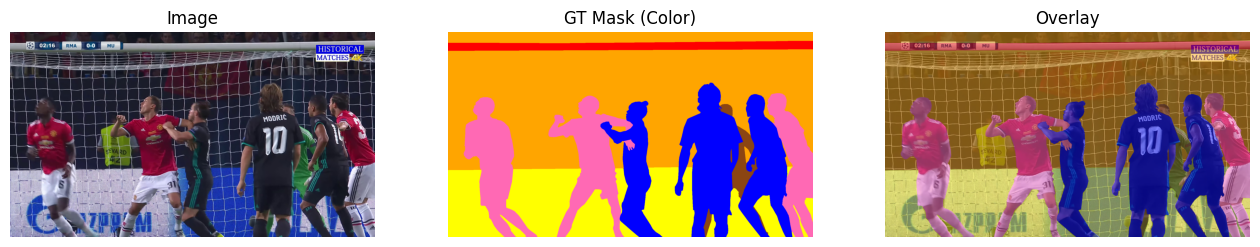

[OK] Saved figure: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\figs\gt_overlay_001.png
[SAMPLE image_id=2] unique labels: [2, 3, 6, 7, 9, 10, 255] 


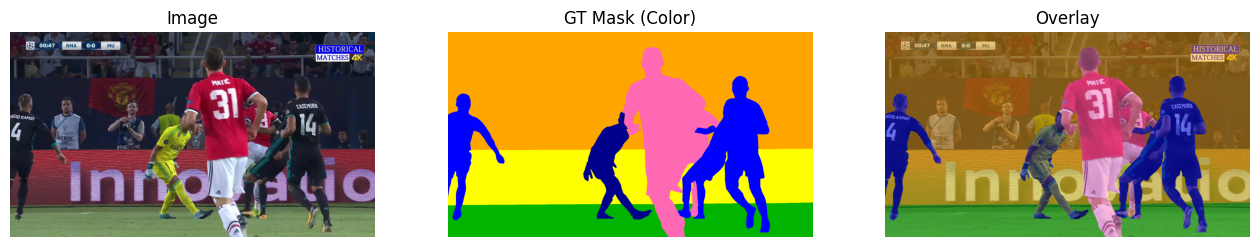

[OK] Saved figure: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\figs\gt_overlay_002.png
[SAMPLE image_id=3] unique labels: [0, 1, 2, 3, 4, 6, 8, 9, 10, 255] 


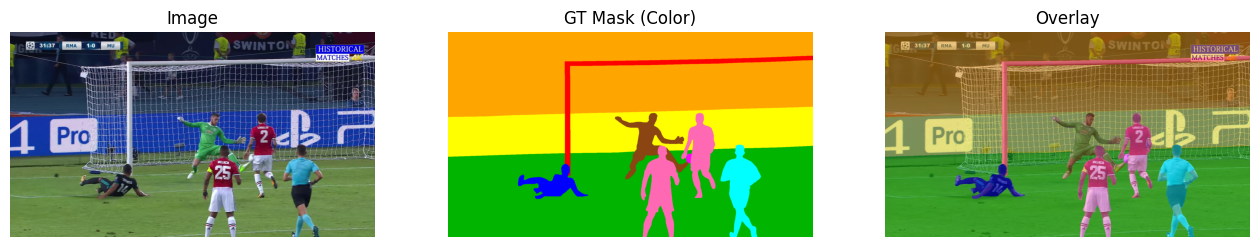

[OK] Saved figure: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\figs\gt_overlay_003.png


In [22]:
# [Code Cell] 4-4. GT 디코딩/오버레이 검증(샘플 N장) + 그림 저장
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import json

# FIGS_OUT_DIR이 4-1에서 만들어졌다는 전제. 혹시 없으면 RUN_DIR 기준으로 fallback 생성.
if "FIGS_OUT_DIR" not in globals():
    RUN_DIR = Path(RUN_DIR)
    RUN_NAME = RUN_DIR.name
    if RUN_DIR.parent.name == "runs":
        GEN_ROOT = RUN_DIR.parent.parent
    else:
        GEN_ROOT = RUN_DIR.parent
    FIGS_OUT_DIR = GEN_ROOT / "figs" / RUN_NAME
    FIGS_OUT_DIR.mkdir(parents=True, exist_ok=True)

mask_index_path = Path(RUN_DIR) / "mask_index.json"
assert mask_index_path.exists(), f"[ERROR] {mask_index_path} 없음. 4-3을 먼저 실행해 주세요."

with open(mask_index_path, "r", encoding="utf-8") as f:
    mi = json.load(f)

mask_index = mi["mask_index"]
assert len(mask_index) > 0, "[ERROR] 생성된 마스크가 없습니다. 4-3 summary를 확인해 주세요."

# 샘플 선택: 앞에서 3장
sample_ids = sorted([int(k) for k in mask_index.keys()])[:3]

def overlay_image(img_rgb: np.ndarray, mask_rgb: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    return (img_rgb * (1 - alpha) + mask_rgb * alpha).astype(np.uint8)

for image_id in sample_ids:
    rec = mask_index[str(image_id)]
    img_path = Path(rec["image_path"])
    msk_path = Path(rec["mask_path"])

    img = np.array(Image.open(img_path).convert("RGB"))
    msk = np.array(Image.open(msk_path))  # (H,W) uint8
    msk_rgb = mask_to_color(msk)
    ov = overlay_image(img, msk_rgb, alpha=0.45)

    uniq = np.unique(msk).tolist()
    print(f"[SAMPLE image_id={image_id}] unique labels:", uniq[:30], ("..." if len(uniq) > 30 else ""))

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1, 3, 2); plt.title("GT Mask (Color)"); plt.imshow(msk_rgb); plt.axis("off")
    plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(ov); plt.axis("off")
    plt.show()

    out_fig = Path(FIGS_OUT_DIR) / f"gt_overlay_{image_id:03d}.png"
    Image.fromarray(ov).save(out_fig)
    print("[OK] Saved figure:", out_fig)

In [23]:
# [Code Cell] 4-5. (선택) GT 픽셀 분포(간이) 계산: 다운샘플 기반 클래스 불균형 파악용
# 원본(1920x1080) 전체 픽셀 집계를 100장 모두 하면 무거울 수 있어,
# 마스크를 작은 크기로 nearest downsample해서 대략적인 분포를 봅니다.

import pandas as pd
from PIL import Image
import numpy as np
from pathlib import Path
import json

mask_index_path = Path(RUN_DIR) / "mask_index.json"
with open(mask_index_path, "r", encoding="utf-8") as f:
    mi = json.load(f)
mask_index = mi["mask_index"]

DOWNSAMPLE = 256  # 속도/대략 분포용
counts = {tid: 0 for tid in range(11)}
ignore_count = 0

for k, rec in mask_index.items():
    m = Image.open(rec["mask_path"])
    m_small = m.resize((DOWNSAMPLE, DOWNSAMPLE), resample=Image.NEAREST)
    arr = np.array(m_small, dtype=np.uint8)

    ignore_count += int((arr == IGNORE_LABEL).sum())
    for tid in range(11):
        counts[tid] += int((arr == tid).sum())

total_labeled = sum(counts.values())
total_all = total_labeled + ignore_count

rows = []
for tid in range(11):
    rows.append({
        "train_id": tid,
        "class_name": tid2name.get(tid, str(tid)),
        "pixel_count_downsampled": counts[tid],
        "ratio_among_labeled": (counts[tid] / total_labeled) if total_labeled > 0 else 0.0,
        "ratio_among_all": (counts[tid] / total_all) if total_all > 0 else 0.0,
    })

df = pd.DataFrame(rows).sort_values("pixel_count_downsampled", ascending=False).reset_index(drop=True)

print("[PIXEL DISTRIBUTION (downsampled)]")
display(df)

out_csv = Path(RUN_DIR) / f"pixel_distribution_downsampled_{DOWNSAMPLE}.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] Saved:", out_csv)

[PIXEL DISTRIBUTION (downsampled)]


,train_id,class_name,pixel_count_downsampled,ratio_among_labeled,ratio_among_all
0,3,Ground,2653943,0.404961,0.404960
1,6,Audience,1641463,0.250468,0.250467
2,2,Advertisement,1023397,0.156158,0.156158
3,10,Team B,537077,0.081952,0.081951
4,9,Team A,460951,0.070336,0.070336
5,0,Goal Bar,94637,0.014440,0.014440
6,7,Goalkeeper A,72677,0.011090,0.011090
7,8,Goalkeeper B,36970,0.005641,0.005641
8,1,Referee,25003,0.003815,0.003815
9,4,Ball,7464,0.001139,0.001139


[OK] Saved: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\pixel_distribution_downsampled_256.csv


## 5. 데이터 분할(Train/Valid/Test) 생성

이 단계에서는 마스크 생성이 완료된 100장을 기준으로  
**Train/Valid/Test**로 데이터를 분할하고, 결과를 파일로 저장한다.

- 고정된 시드로 분할하여 재현성을 확보한다.
- split별로 어떤 이미지/마스크가 들어갔는지 인덱스(CSV/JSON)를 저장한다.

> Test는 최종 “일반화 성능 평가”용이므로, 학습 과정에서 보지 않도록 분리한다.

In [24]:
# [Code Cell] 5-1. mask_index 로드 + 학습용 레코드 테이블 구성
from pathlib import Path
import json
import pandas as pd

try:
    ROOT, RUN_DIR, DIRS, CFG
except NameError:
    raise RuntimeError("0~4번 셀을 먼저 실행해 주세요. (ROOT/RUN_DIR/DIRS/CFG 필요)")

mask_index_path = Path(RUN_DIR) / "mask_index.json"
assert mask_index_path.exists(), f"[ERROR] mask_index.json이 없습니다: {mask_index_path} (4-3 셀 실행 필요)"

with open(mask_index_path, "r", encoding="utf-8") as f:
    mi = json.load(f)

mask_index = mi.get("mask_index", {})
stats = mi.get("stats", {})
errors = mi.get("errors", [])

assert len(mask_index) > 0, "[ERROR] mask_index가 비어있습니다. 4-3 결과를 확인해 주세요."
assert len(errors) == 0, "[ERROR] 마스크 생성 과정에서 errors가 존재합니다. 4-3의 errors를 먼저 해결해 주세요."

rows = []
for k, rec in mask_index.items():
    rows.append({
        "image_id": int(rec["image_id"]),
        "file_name": rec.get("file_name"),
        "image_path": rec.get("image_path"),
        "mask_path": rec.get("mask_path"),
        "width": int(rec.get("width")) if rec.get("width") is not None else None,
        "height": int(rec.get("height")) if rec.get("height") is not None else None,
        "ignore_ratio": float(rec.get("ignore_ratio")) if rec.get("ignore_ratio") is not None else None,
    })

df_all = pd.DataFrame(rows).sort_values("image_id").reset_index(drop=True)

print("[MASK INDEX LOADED]")
print(" - total records:", len(df_all))
print(" - example rows:")
display(df_all.head(3))

[MASK INDEX LOADED]
 - total records: 100
 - example rows:


,image_id,file_name,image_path,mask_path,width,height,ignore_ratio
0,1,Frame 1 (14).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,0.000000e+00
1,2,Frame 1 (12).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07
2,3,Frame 1 (18).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07


In [25]:
# [Code Cell] 5-2. Train/Valid/Test 분할(시드 고정) + 무결성 검사
import numpy as np

SEED = int(CFG.get("seed", 42))
train_ratio = float(CFG.get("train_split", 0.70))
valid_ratio = float(CFG.get("valid_split", 0.15))
test_ratio  = float(CFG.get("test_split",  0.15))

assert abs((train_ratio + valid_ratio + test_ratio) - 1.0) < 1e-6, "[ERROR] split 비율 합이 1.0이 아닙니다."

ids = df_all["image_id"].tolist()
n = len(ids)

rng = np.random.default_rng(SEED)
shuffled = ids.copy()
rng.shuffle(shuffled)

n_train = int(round(n * train_ratio))
n_valid = int(round(n * valid_ratio))

# 라운딩으로 합이 어긋나는 경우 보정
if n_train + n_valid > n:
    n_valid = n - n_train
n_test = n - (n_train + n_valid)

train_ids = sorted(shuffled[:n_train])
valid_ids = sorted(shuffled[n_train:n_train + n_valid])
test_ids  = sorted(shuffled[n_train + n_valid:])

# 무결성 검사(겹침/누락)
set_train, set_valid, set_test = set(train_ids), set(valid_ids), set(test_ids)
assert len(set_train & set_valid) == 0, "[ERROR] train/valid overlap"
assert len(set_train & set_test) == 0, "[ERROR] train/test overlap"
assert len(set_valid & set_test) == 0, "[ERROR] valid/test overlap"
assert len(set_train | set_valid | set_test) == n, "[ERROR] split union != total"

print("[SPLIT SUMMARY]")
print(" - seed :", SEED)
print(" - total:", n)
print(" - train:", len(train_ids))
print(" - valid:", len(valid_ids))
print(" - test :", len(test_ids))
print(" - ratios:", (train_ratio, valid_ratio, test_ratio))

[SPLIT SUMMARY]
 - seed : 42
 - total: 100
 - train: 70
 - valid: 15
 - test : 15
 - ratios: (0.7, 0.15, 0.15)


In [27]:
# [Code Cell] 5-3. split 인덱스 파일 저장(splits.json / csv / txt) + 경로 출력 (경로 통일 + 안전)
from pathlib import Path
import json

try:
    RUN_DIR, DIRS, SEED, train_ratio, valid_ratio, test_ratio
    n, train_ids, valid_ids, test_ids
    df_all, set_train, set_valid
except NameError:
    raise RuntimeError("이 셀 실행 전에 split 생성에 필요한 변수들이 준비되어야 합니다. (RUN_DIR/DIRS/df_all/train_ids 등)")

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정 (다른 셀들과 동일 규칙)
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

# SPLITS 루트 결정: DIRS["SPLITS"]가 있으면 우선, 없으면 GEN_ROOT/splits fallback
if isinstance(DIRS, dict) and ("SPLITS" in DIRS):
    SPLITS_ROOT = Path(DIRS["SPLITS"])
else:
    SPLITS_ROOT = GEN_ROOT / "splits"

SPLIT_OUT_DIR = SPLITS_ROOT / RUN_NAME
SPLIT_OUT_DIR.mkdir(parents=True, exist_ok=True)

splits = {
    "seed": SEED,
    "ratios": {"train": train_ratio, "valid": valid_ratio, "test": test_ratio},
    "counts": {"total": n, "train": len(train_ids), "valid": len(valid_ids), "test": len(test_ids)},
    "train_ids": train_ids,
    "valid_ids": valid_ids,
    "test_ids": test_ids,
}

# JSON 저장
splits_json_path = SPLIT_OUT_DIR / "splits.json"
with open(splits_json_path, "w", encoding="utf-8") as f:
    json.dump(splits, f, indent=2, ensure_ascii=False)

# txt 저장
def save_txt(path: Path, items):
    with open(path, "w", encoding="utf-8") as f:
        for x in items:
            f.write(str(x) + "\n")

save_txt(SPLIT_OUT_DIR / "train_ids.txt", train_ids)
save_txt(SPLIT_OUT_DIR / "valid_ids.txt", valid_ids)
save_txt(SPLIT_OUT_DIR / "test_ids.txt", test_ids)

# CSV 인덱스 저장
def assign_split(image_id: int) -> str:
    if image_id in set_train:
        return "train"
    if image_id in set_valid:
        return "valid"
    return "test"

df_split = df_all.copy()
df_split["split"] = df_split["image_id"].apply(assign_split)

split_csv_path = SPLIT_OUT_DIR / "split_index.csv"
df_split.to_csv(split_csv_path, index=False, encoding="utf-8-sig")

# RUN_DIR에도 바로가기용 저장(유지)
splits_json_run = RUN_DIR / "splits.json"
with open(splits_json_run, "w", encoding="utf-8") as f:
    json.dump(splits, f, indent=2, ensure_ascii=False)

print("[OK] Saved split files to:")
print(" - SPLIT_OUT_DIR:", SPLIT_OUT_DIR)
print("[FILES]")
print(" - splits.json   :", splits_json_path)
print(" - split_index.csv:", split_csv_path)
print(" - train_ids.txt :", SPLIT_OUT_DIR / "train_ids.txt")
print(" - valid_ids.txt :", SPLIT_OUT_DIR / "valid_ids.txt")
print(" - test_ids.txt  :", SPLIT_OUT_DIR / "test_ids.txt")
print(" - shortcut (RUN_DIR/splits.json):", splits_json_run)
print("[DEBUG PATHS]")
print(" - RUN_DIR :", RUN_DIR)
print(" - GEN_ROOT:", GEN_ROOT)
print(" - SPLITS_ROOT:", SPLITS_ROOT)

[OK] Saved split files to:
 - SPLIT_OUT_DIR: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626
[FILES]
 - splits.json   : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626\splits.json
 - split_index.csv: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626\split_index.csv
 - train_ids.txt : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626\train_ids.txt
 - valid_ids.txt : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626\valid_ids.txt
 - test_ids.txt  : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626\test_ids.txt
 - shortcut (RUN_DIR/splits.json): c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\runs\run_20260126_104626\splits.json
[DEBUG PATHS]
 - RUN_DIR : c:\Users\amy\Desktop\sprint\spr

In [28]:
# [Code Cell] 5-4. 분할 결과 미리보기(각 split 상위 3개 샘플) + 경로 점검
import pandas as pd

print("[TRAIN SAMPLE]")
display(df_split[df_split["split"] == "train"].head(3))

print("[VALID SAMPLE]")
display(df_split[df_split["split"] == "valid"].head(3))

print("[TEST SAMPLE]")
display(df_split[df_split["split"] == "test"].head(3))

# 경로 존재 체크(빠른 sanity)
from pathlib import Path

def path_exists(p):
    return Path(p).exists()

ok_img = df_split["image_path"].apply(path_exists).mean()
ok_msk = df_split["mask_path"].apply(path_exists).mean()

print("[PATH CHECK]")
print(" - image_path exists ratio:", float(ok_img))
print(" - mask_path exists ratio :", float(ok_msk))

[TRAIN SAMPLE]


,image_id,file_name,image_path,mask_path,width,height,ignore_ratio,split
0,1,Frame 1 (14).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,0.000000e+00,train
1,2,Frame 1 (12).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,train
2,3,Frame 1 (18).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,train


[VALID SAMPLE]


,image_id,file_name,image_path,mask_path,width,height,ignore_ratio,split
6,7,Frame 1 (16).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,valid
11,12,Frame 1 (7).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,9.645062e-07,valid
30,31,Frame 1 (15).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,3.375772e-06,valid


[TEST SAMPLE]


,image_id,file_name,image_path,mask_path,width,height,ignore_ratio,split
8,9,Frame 1 (13).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,test
12,13,Frame 1 (23).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,test
13,14,Frame 1 (11).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,test


[PATH CHECK]
 - image_path exists ratio: 1.0
 - mask_path exists ratio : 1.0


## 6. 전처리 및 데이터 증강 설계

이 단계에서는 학습에 사용할 전처리/증강 파이프라인을 정의한다.  
세그멘테이션은 이미지와 마스크가 픽셀 단위로 정렬되어야 하므로 변환 규칙을 엄격히 지킨다.

- Train용 변환: 일반화 성능 향상을 위한 augmentation 포함  
- Valid/Test용 변환: 평가의 공정성을 위해 최소 변환(주로 Resize/Normalize)만 적용

주의사항
- 기하학 변환(Resize/Crop/Flip)은 **이미지와 마스크에 동일하게 적용**
- 마스크는 라벨 값이 깨지지 않도록 **nearest 방식**으로 처리

> 이 단계가 잘못되면 “GT가 뒤틀린 채 학습”되어 성능이 크게 하락할 수 있다.

In [29]:
# [Code Cell] 6-1. 필수 설정 로드 + 변환 파이프라인에서 쓸 상수 정의
from pathlib import Path
import json

try:
    RUN_DIR, CFG
except NameError:
    raise RuntimeError("0~5번 셀을 먼저 실행해 주세요. (RUN_DIR/CFG 필요)")

IMG_SIZE = int(CFG.get("img_size", 384))
IGNORE_LABEL = 255  # 4번과 동일 규칙
SEED = int(CFG.get("seed", 42))

print("[CONFIG]")
print(" - IMG_SIZE     :", IMG_SIZE)
print(" - IGNORE_LABEL :", IGNORE_LABEL)
print(" - SEED         :", SEED)

# split 인덱스 로드(다음 단계에서 Dataset 구성 시 필요)
splits_path = Path(RUN_DIR) / "splits.json"
assert splits_path.exists(), f"[ERROR] splits.json이 없습니다: {splits_path} (5-3 셀 실행 필요)"

with open(splits_path, "r", encoding="utf-8") as f:
    splits = json.load(f)

print("[SPLITS]")
print(" - train:", len(splits["train_ids"]))
print(" - valid:", len(splits["valid_ids"]))
print(" - test :", len(splits["test_ids"]))

[CONFIG]
 - IMG_SIZE     : 384
 - IGNORE_LABEL : 255
 - SEED         : 42
[SPLITS]
 - train: 70
 - valid: 15
 - test : 15


In [30]:
# [Code Cell] 6-2. Albumentations 기반 전처리/증강 정의(이미지+마스크 동시 적용)
# 설치가 안 되어 있으면 설치 안내 에러가 뜰 수 있음.
# VSCode 환경에 따라 pip 설치가 필요할 수 있음.

import numpy as np

try:
    import albumentations as A
except Exception as e:
    raise RuntimeError(
        "albumentations import 실패. 환경에 따라 설치가 필요할 수 있습니다.\n"
        "예) pip install albumentations opencv-python\n"
        f"원인: {e}"
    )

# 학습용 변환: resize + (flip/crop/brightness-contrast) + normalize
# 원본이 1920x1080(가로가 더 김)이므로, 먼저 LongestMaxSize로 축소 후 Pad로 정사각 고정도 가능
# 여기서는 단순화를 위해 Resize를 기본으로 두고, 필요 시 7~8번에서 개선 가능
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=1),  # image: bilinear
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.03, scale_limit=0.08, rotate_limit=8,
        border_mode=0, value=0, mask_value=IGNORE_LABEL, p=0.4
    ),
], additional_targets={"mask": "mask"})

# 검증/테스트: resize만(결과 비교 일관성)
eval_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=1),
], additional_targets={"mask": "mask"})

print("[OK] Albumentations transforms are ready.")

[OK] Albumentations transforms are ready.


c:\Users\amy\Desktop\sprint\sprint-ai07\venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\amy\AppData\Local\Temp\ipykernel_33216\3283062822.py:23: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(


In [31]:
# [Code Cell] 6-3. 변환 적용 sanity 함수(마스크는 nearest 유지 확인용)
from PIL import Image
import numpy as np
import random
from pathlib import Path
import json

# mask_index 로드해서 샘플 하나 뽑기
mask_index_path = Path(RUN_DIR) / "mask_index.json"
with open(mask_index_path, "r", encoding="utf-8") as f:
    mi = json.load(f)
mask_index = mi["mask_index"]

sample_id = sorted([int(k) for k in mask_index.keys()])[0]
rec = mask_index[str(sample_id)]

img = np.array(Image.open(rec["image_path"]).convert("RGB"))
msk = np.array(Image.open(rec["mask_path"]))  # (H,W) 0~10 or 255

# train transform 적용
out = train_tfms(image=img, mask=msk)
img_t = out["image"]
msk_t = out["mask"]

print("[SANITY]")
print(" - original image:", img.shape, img.dtype)
print(" - original mask :", msk.shape, msk.dtype, "unique:", np.unique(msk)[:20])
print(" - transformed image:", img_t.shape, img_t.dtype)
print(" - transformed mask :", msk_t.shape, msk_t.dtype, "unique:", np.unique(msk_t)[:20])

# 마스크 값이 정수 라벨로 유지되는지(근처값 생기면 안 됨)
uniq = np.unique(msk_t)
bad = [x for x in uniq.tolist() if (x != IGNORE_LABEL and (x < 0 or x > 10))]
assert len(bad) == 0, f"[ERROR] 변환된 마스크에 이상 라벨이 포함됨: {bad}"

print("[OK] mask labels are valid after transform.")

[SANITY]
 - original image: (1080, 1920, 3) uint8
 - original mask : (1080, 1920) uint8 unique: [ 0  2  6  8  9 10]
 - transformed image: (384, 384, 3) uint8
 - transformed mask : (384, 384) uint8 unique: [ 0  2  6  8  9 10]
[OK] mask labels are valid after transform.


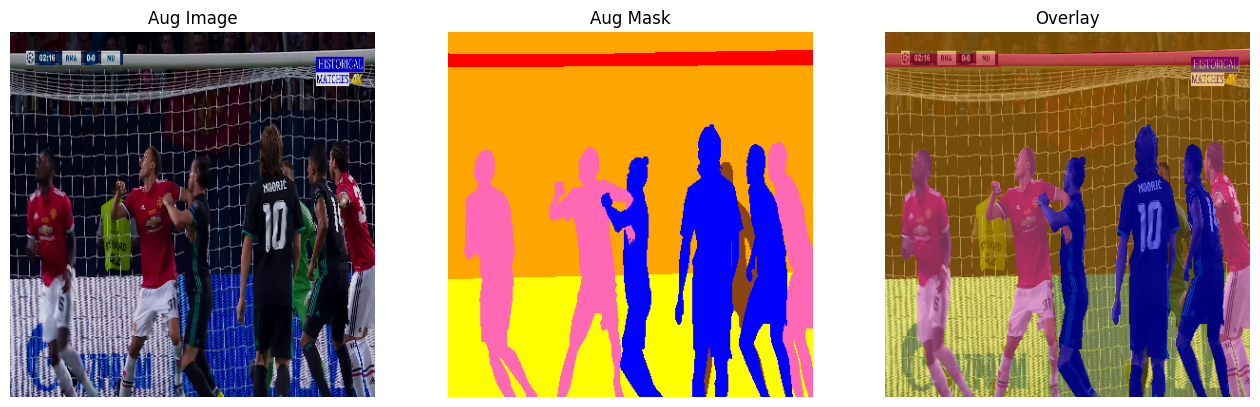

In [32]:
# [Code Cell] 6-4. (선택) 변환 후 오버레이 시각화(학습 증강이 자연스러운지 확인)
import matplotlib.pyplot as plt
import numpy as np

# class_mapping 로드(팔레트)
map_path = Path(RUN_DIR) / "class_mapping.json"
with open(map_path, "r", encoding="utf-8") as f:
    class_map = json.load(f)
palette = {int(k): v for k, v in class_map["palette_rgb"].items()}

def mask_to_color_local(mask: np.ndarray) -> np.ndarray:
    h, w = mask.shape
    out = np.zeros((h, w, 3), dtype=np.uint8)
    for tid, rgb in palette.items():
        out[mask == tid] = np.array(rgb, dtype=np.uint8)
    return out

def overlay(img_rgb, mask_rgb, alpha=0.45):
    return (img_rgb * (1 - alpha) + mask_rgb * alpha).astype(np.uint8)

mask_rgb = mask_to_color_local(msk_t)
ov = overlay(img_t, mask_rgb, alpha=0.45)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1); plt.title("Aug Image"); plt.imshow(img_t); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Aug Mask"); plt.imshow(mask_rgb); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(ov); plt.axis("off")
plt.show()

## 7. Dataset / DataLoader 구성 및 샘플 검증

이 단계에서는 split 인덱스를 기반으로 PyTorch Dataset/DataLoader를 구성하고,  
학습 직전에 데이터 파이프라인이 정상인지 sanity check를 수행한다.

- Dataset 반환 포맷(예시)
  - image: FloatTensor (3, H, W)
  - mask : LongTensor (H, W), 값은 {0~10, 255(IGNORE)}

- DataLoader
  - batch 로딩, shuffle, num_workers 등을 설정한다.

- Sanity check
  - 배치 shape/dtype 확인
  - 라벨 범위(0~10/255) 확인
  - 샘플 시각화로 변환 적용이 올바른지 확인

> 학습 실패의 상당수는 Dataset/Loader 단계에서 발생하므로, 이 단계 점검이 시간을 절약한다.

In [33]:
# [Code Cell] 7-1. 의존성 로드 + split_index.csv 로드
from pathlib import Path
import json
import pandas as pd

try:
    RUN_DIR, CFG
except NameError:
    raise RuntimeError("0~6번 셀을 먼저 실행해 주세요. (RUN_DIR/CFG 필요)")

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

# split_index.csv는 5-3에서 splits/<RUN_NAME>/split_index.csv로 저장된다고 가정
SPLITS_ROOT = GEN_ROOT / "splits"
split_dir = SPLITS_ROOT / RUN_NAME
split_csv = split_dir / "split_index.csv"

assert split_csv.exists(), f"[ERROR] split_index.csv가 없습니다: {split_csv} (5-3 실행 확인)"

df_split = pd.read_csv(split_csv)
assert {"image_id", "image_path", "mask_path", "split"}.issubset(df_split.columns), "[ERROR] split_index.csv 컬럼이 부족합니다."

print("[OK] Loaded:", split_csv)
print(df_split["split"].value_counts())
display(df_split.head(3))

[OK] Loaded: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\splits\run_20260126_104626\split_index.csv
split
train    70
valid    15
test     15
Name: count, dtype: int64


,image_id,file_name,image_path,mask_path,width,height,ignore_ratio,split
0,1,Frame 1 (14).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,0.000000e+00,train
1,2,Frame 1 (12).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,train
2,3,Frame 1 (18).jpg,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,c:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,1920,1080,4.822531e-07,train


In [34]:
# [Code Cell] 7-2. Dataset 클래스 정의(Albumentations 적용) + 기본 검증 함수
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import torch

IMG_SIZE = int(CFG.get("img_size", 384))
IGNORE_LABEL = 255

class FootballSegDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = str(row["image_path"])
        mask_path = str(row["mask_path"])

        img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)
        msk = np.array(Image.open(mask_path), dtype=np.uint8)  # (H,W) 0~10 or 255

        if self.transforms is not None:
            out = self.transforms(image=img, mask=msk)
            img = out["image"]
            msk = out["mask"]

        # torch tensor 변환
        # image: (H,W,3) -> (3,H,W), float32 [0,1]
        img_t = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

        # mask: (H,W) -> long (CrossEntropy용)
        msk_t = torch.from_numpy(msk).long()

        return {
            "image": img_t,
            "mask": msk_t,
            "image_id": int(row["image_id"]),
            "image_path": img_path,
            "mask_path": mask_path,
        }

def quick_sample_check(ds: Dataset, n=3):
    for i in range(min(n, len(ds))):
        b = ds[i]
        x = b["image"]
        y = b["mask"]
        print(f"[SAMPLE {i}] image_id={b['image_id']}")
        print(" - image:", tuple(x.shape), x.dtype, "min/max:", float(x.min()), float(x.max()))
        uniq = torch.unique(y).cpu().numpy().tolist()
        print(" - mask :", tuple(y.shape), y.dtype, "unique(head):", uniq[:25], ("..." if len(uniq) > 25 else ""))
        # 값 범위 체크(0~10 or 255)
        bad = [v for v in uniq if (v != IGNORE_LABEL and (v < 0 or v > 10))]
        assert len(bad) == 0, f"[ERROR] mask에 이상 라벨 포함: {bad}"

print("[OK] Dataset class ready.")

[OK] Dataset class ready.


In [35]:
# [Code Cell] 7-3. split별 Dataset 생성(train/valid/test) + 샘플 확인
# 6번에서 정의한 train_tfms/eval_tfms를 그대로 사용
try:
    train_tfms, eval_tfms
except NameError:
    raise RuntimeError("6번 셀에서 train_tfms/eval_tfms를 먼저 정의해 주세요.")

df_train = df_split[df_split["split"] == "train"].copy()
df_valid = df_split[df_split["split"] == "valid"].copy()
df_test  = df_split[df_split["split"] == "test"].copy()

train_ds = FootballSegDataset(df_train, transforms=train_tfms)
valid_ds = FootballSegDataset(df_valid, transforms=eval_tfms)
test_ds  = FootballSegDataset(df_test,  transforms=eval_tfms)

print("[DATASET SIZE]")
print(" - train:", len(train_ds))
print(" - valid:", len(valid_ds))
print(" - test :", len(test_ds))

print("\n[TRAIN SAMPLE CHECK]")
quick_sample_check(train_ds, n=2)

print("\n[VALID SAMPLE CHECK]")
quick_sample_check(valid_ds, n=1)

[DATASET SIZE]
 - train: 70
 - valid: 15
 - test : 15

[TRAIN SAMPLE CHECK]
[SAMPLE 0] image_id=1
 - image: (3, 384, 384) torch.float32 min/max: 0.0 1.0
 - mask : (384, 384) torch.int64 unique(head): [0, 2, 6, 8, 9, 10] 
[SAMPLE 1] image_id=2
 - image: (3, 384, 384) torch.float32 min/max: 0.0 1.0
 - mask : (384, 384) torch.int64 unique(head): [2, 3, 6, 7, 9, 10] 

[VALID SAMPLE CHECK]
[SAMPLE 0] image_id=7
 - image: (3, 384, 384) torch.float32 min/max: 0.0 1.0
 - mask : (384, 384) torch.int64 unique(head): [0, 1, 2, 3, 6, 8, 9, 10] 


In [36]:
# [Code Cell] 7-4a. (디버그) num_workers=0으로 실제 에러 원인(traceback) 노출
from torch.utils.data import DataLoader
import torch

# 안전한 기본값(Windows 디버그용)
BATCH_SIZE = int(CFG.get("batch_size", 4))
NUM_WORKERS = 0  # 디버그: 반드시 0

# GPU 있으면 pin_memory 사용해도 되지만, 디버그에서는 꺼도 무방
pin = False

train_loader_dbg = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin,
)

print("[DEBUG LOADER]")
print(" - batch_size :", BATCH_SIZE)
print(" - num_workers:", NUM_WORKERS)
print(" - pin_memory :", pin)

batch = next(iter(train_loader_dbg))
x = batch["image"]
y = batch["mask"]

print("[BATCH SANITY - DEBUG]")
print(" - image batch:", tuple(x.shape), x.dtype)
print(" - mask batch :", tuple(y.shape), y.dtype)
print(" - image min/max:", float(x.min()), float(x.max()))
uniq = torch.unique(y).cpu().numpy().tolist()
print(" - mask unique(head):", uniq[:30], ("..." if len(uniq) > 30 else ""))

assert x.ndim == 4 and x.shape[1] == 3 and x.shape[2] == IMG_SIZE and x.shape[3] == IMG_SIZE, "[ERROR] image batch shape 이상"
assert y.ndim == 3 and y.shape[1] == IMG_SIZE and y.shape[2] == IMG_SIZE, "[ERROR] mask batch shape 이상"

print("[OK] Debug DataLoader sanity check passed.")

[DEBUG LOADER]
 - batch_size : 4
 - num_workers: 0
 - pin_memory : False
[BATCH SANITY - DEBUG]
 - image batch: (4, 3, 384, 384) torch.float32
 - mask batch : (4, 384, 384) torch.int64
 - image min/max: 0.0 1.0
 - mask unique(head): [0, 2, 3, 4, 6, 7, 8, 9, 10] 
[OK] Debug DataLoader sanity check passed.


In [37]:
# [Code Cell] 7-6. (확정) train/valid/test DataLoader 생성 (Windows 안정 모드)
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = int(CFG.get("batch_size", 4))
NUM_WORKERS = 0  # Windows 안정 모드 고정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = True if device.type == "cuda" else False

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=pin
)
valid_loader = DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=pin
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=pin
)

print("[LOADER READY]")
print(" - device     :", device)
print(" - batch_size :", BATCH_SIZE)
print(" - num_workers:", NUM_WORKERS)
print(" - pin_memory :", pin)
print(" - train/valid/test:", len(train_ds), len(valid_ds), len(test_ds))

[LOADER READY]
 - device     : cuda
 - batch_size : 4
 - num_workers: 0
 - pin_memory : True
 - train/valid/test: 70 15 15


In [38]:
# [Code Cell] 7-7. 최종 배치 sanity check (학습 직전 확인)
import torch

batch = next(iter(train_loader))
x = batch["image"]
y = batch["mask"]

print("[BATCH SANITY - FINAL]")
print(" - image batch:", tuple(x.shape), x.dtype)
print(" - mask batch :", tuple(y.shape), y.dtype)
print(" - mask unique(head):", torch.unique(y).cpu().numpy().tolist()[:30])

assert x.shape[1] == 3 and x.shape[2] == IMG_SIZE and x.shape[3] == IMG_SIZE
assert y.shape[1] == IMG_SIZE and y.shape[2] == IMG_SIZE
print("[OK] Ready for training.")

[BATCH SANITY - FINAL]
 - image batch: (4, 3, 384, 384) torch.float32
 - mask batch : (4, 384, 384) torch.int64
 - mask unique(head): [0, 2, 3, 4, 6, 7, 8, 9, 10]
[OK] Ready for training.


## 8. U-Net 모델 정의 및 Loss/Metric 구성

이 단계에서는 11클래스 세그멘테이션을 위한 **U-Net** 모델과  
학습/평가에 사용할 손실함수 및 지표를 구성한다.

### 모델 (U-Net)
- encoder-decoder 구조 + skip connection으로
  저수준(경계) 정보와 고수준(문맥) 정보를 결합해 마스크 복원에 유리하다.

### Loss
- **CrossEntropyLoss(ignore_index=255)**
  - 라벨이 없는 픽셀(IGNORE)을 손실 계산에서 제외해 왜곡을 방지한다.
- **Dice Loss(멀티클래스)**
  - 클래스 불균형(특히 Ball처럼 작은 객체)에서 overlap 기반 학습 신호를 강화한다.

### Metric
- mIoU, mean Dice를 계산할 수 있도록 함수화한다.

> “CE로 안정적인 수렴 + Dice로 작은 객체 보완”이 기본 목표다.

In [39]:
# [Code Cell] 8-1 (정리 버전: 설정 X, 확인만)
print("device:", device)
print("seed:", SEED)

device: cuda
seed: 42


In [40]:
# [Code Cell] 8-2. U-Net 구성 블록 정의(DoubleConv / Down / Up / OutConv)
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch),
        )

    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # padding(홀수 크기 대응)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

print("[OK] UNet blocks ready.")

[OK] UNet blocks ready.


In [41]:
# [Code Cell] 8-3. U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=11, base_c=32, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, base_c)
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor)

        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.outc = OutConv(base_c, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

NUM_CLASSES = 11
model = UNet(n_channels=3, n_classes=NUM_CLASSES, base_c=32, bilinear=True).to(device)

# 파라미터 수
n_params = sum(p.numel() for p in model.parameters())
print("[MODEL] UNet params:", n_params)


[MODEL] UNet params: 3350603


In [42]:
# [Code Cell] 8-4. Loss 정의: CrossEntropy(ignore) + Multi-class Dice Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

IGNORE_LABEL = 255

ce_loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_LABEL)

def dice_loss_multiclass(logits, target, num_classes=11, ignore_index=255, eps=1e-6):
    """
    logits: (B,C,H,W)
    target: (B,H,W) long
    """
    # ignore mask
    valid = (target != ignore_index)
    if valid.sum() == 0:
        return torch.tensor(0.0, device=logits.device)

    # one-hot (valid only)
    # target_valid shape: (N,) where N=valid pixels
    target_valid = target[valid]
    logits_valid = logits.permute(0, 2, 3, 1)[valid]  # (N,C)

    probs = F.softmax(logits_valid, dim=-1)  # (N,C)
    target_oh = F.one_hot(target_valid, num_classes=num_classes).float()  # (N,C)

    # dice per class
    intersect = (probs * target_oh).sum(dim=0)  # (C,)
    denom = (probs + target_oh).sum(dim=0)      # (C,)
    dice = (2 * intersect + eps) / (denom + eps)

    # GT가 없는 클래스는 dice 계산에서 제외(특히 Coaches & Officials = 0개 대응)
    gt_sum = target_oh.sum(dim=0)  # (C,)
    present = (gt_sum > 0)
    if present.sum() == 0:
        return torch.tensor(0.0, device=logits.device)

    return 1.0 - dice[present].mean()

def combined_loss(logits, target, lam_dice=0.5):
    ce = ce_loss_fn(logits, target)
    dl = dice_loss_multiclass(logits, target, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL)
    return ce + lam_dice * dl, {"ce": ce.item(), "dice": dl.item()}

print("[OK] Loss functions ready.")

[OK] Loss functions ready.


In [43]:
# [Code Cell] 8-5. Metric: mIoU (GT 존재 클래스만 평균) + Dice score
import torch
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def compute_confusion_matrix(pred, target, num_classes=11, ignore_index=255):
    """
    pred: (B,H,W) long
    target: (B,H,W) long
    returns: (C,C) confusion matrix
    """
    valid = (target != ignore_index)
    pred = pred[valid].view(-1)
    target = target[valid].view(-1)
    if target.numel() == 0:
        return torch.zeros((num_classes, num_classes), dtype=torch.int64, device=pred.device)

    k = (target * num_classes + pred).to(torch.int64)
    cm = torch.bincount(k, minlength=num_classes * num_classes).reshape(num_classes, num_classes)
    return cm

@torch.no_grad()
def compute_miou_from_cm(cm: torch.Tensor):
    """
    cm: (C,C)
    """
    diag = torch.diag(cm).float()
    denom = (cm.sum(dim=1) + cm.sum(dim=0) - diag).float()
    iou = diag / (denom + 1e-6)

    # GT가 없는 클래스는 제외 (row sum == 0)
    present = (cm.sum(dim=1) > 0)
    if present.sum() == 0:
        return 0.0, iou.detach().cpu().numpy().tolist()

    miou = iou[present].mean().item()
    return miou, iou.detach().cpu().numpy().tolist()

@torch.no_grad()
def compute_mean_dice(pred, target, num_classes=11, ignore_index=255):
    valid = (target != ignore_index)
    if valid.sum() == 0:
        return 0.0

    pred = pred[valid]
    target = target[valid]

    dice_list = []
    for c in range(num_classes):
        gt = (target == c)
        if gt.sum() == 0:
            continue
        pr = (pred == c)
        inter = (gt & pr).sum().float()
        denom = gt.sum().float() + pr.sum().float()
        dice = (2 * inter + 1e-6) / (denom + 1e-6)
        dice_list.append(dice.item())

    if len(dice_list) == 0:
        return 0.0
    return float(np.mean(dice_list))

print("[OK] Metrics ready.")

[OK] Metrics ready.


In [44]:
# [Code Cell] 8-6. Forward pass sanity (1 batch) + loss 계산 확인
import torch

model.eval()
batch = next(iter(train_loader))
x = batch["image"].to(device)
y = batch["mask"].to(device)

with torch.no_grad():
    logits = model(x)  # (B,C,H,W)

print("[FORWARD]")
print(" - x:", tuple(x.shape), x.dtype)
print(" - y:", tuple(y.shape), y.dtype)
print(" - logits:", tuple(logits.shape), logits.dtype)

loss_val, loss_parts = combined_loss(logits, y, lam_dice=0.5)
print("[LOSS]")
print(" - total:", float(loss_val.item()))
print(" - parts:", loss_parts)

pred = torch.argmax(logits, dim=1)
cm = compute_confusion_matrix(pred, y, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL)
miou, iou_per_class = compute_miou_from_cm(cm)
mdice = compute_mean_dice(pred, y, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL)

print("[METRIC]")
print(" - mIoU:", miou)
print(" - mean Dice:", mdice)

[FORWARD]
 - x: (4, 3, 384, 384) torch.float32
 - y: (4, 384, 384) torch.int64
 - logits: (4, 11, 384, 384) torch.float32
[LOSS]
 - total: 2.8802330493927
 - parts: {'ce': 2.412883758544922, 'dice': 0.9346987009048462}
[METRIC]
 - mIoU: 0.00027025010786019266
 - mean Dice: 0.0005390437863599357


## 9. 학습 루프 구성(Train/Valid) + Best 모델 저장

이 단계에서는 학습을 위한 전체 루프를 구성하고, best 모델을 저장한다.

1) Optimizer / Scheduler 설정  
- AdamW 및 LR 스케줄을 설정한다.

2) Train / Valid 반복  
- epoch마다 Train loss를 계산하고,
- Valid에서는 mIoU/mean Dice로 성능을 측정한다.

3) Best checkpoint 저장  
- **Valid mIoU가 최고(best)** 인 시점의 가중치를 저장한다.
  (마지막 epoch가 항상 최고 성능은 아니기 때문)

4) 로그 저장  
- 학습 로그를 CSV로 남겨 결과표/학습곡선 작성이 가능하게 한다.

In [45]:
# [Code Cell] 9-1. (재수정) optimizer/scheduler + ckpts/logs 경로 안전 생성
import torch
import torch.optim as optim
from pathlib import Path
import numpy as np
import time
import pandas as pd
import json

try:
    model, device, train_loader, valid_loader, RUN_DIR, CFG
except NameError:
    raise RuntimeError("8번(모델/로스/메트릭)과 7번(loader)까지 먼저 실행해 주세요.")

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

# 하이퍼파라미터
EPOCHS = int(CFG.get("epochs", 40))
LR = float(CFG.get("lr", 3e-4))
WEIGHT_DECAY = float(CFG.get("weight_decay", 1e-4))
LAMBDA_DICE = float(CFG.get("lambda_dice", 0.5))

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# PyTorch 버전 호환: verbose 제거
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3, min_lr=1e-6
)

print("[HYPERPARAMS]")
print(" - EPOCHS      :", EPOCHS)
print(" - LR          :", LR)
print(" - WEIGHT_DECAY:", WEIGHT_DECAY)
print(" - LAMBDA_DICE :", LAMBDA_DICE)

# 저장 폴더(자동 생성) - 전부 GEN_ROOT 기준으로 통일
CKPT_DIR = GEN_ROOT / "ckpts" / RUN_NAME
LOG_DIR  = GEN_ROOT / "logs"  / RUN_NAME

CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

best_path = CKPT_DIR / "best_miou.pt"
last_path = CKPT_DIR / "last.pt"
log_csv_path = LOG_DIR / "train_log.csv"

print("[PATHS]")
print(" - GEN_ROOT :", GEN_ROOT)
print(" - CKPT_DIR :", CKPT_DIR)
print(" - LOG_DIR  :", LOG_DIR)
print(" - best     :", best_path)
print(" - last     :", last_path)
print(" - log csv  :", log_csv_path)

[HYPERPARAMS]
 - EPOCHS      : 40
 - LR          : 0.0003
 - WEIGHT_DECAY: 0.0001
 - LAMBDA_DICE : 0.5
[PATHS]
 - GEN_ROOT : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated
 - CKPT_DIR : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\ckpts\run_20260126_104626
 - LOG_DIR  : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\logs\run_20260126_104626
 - best     : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\ckpts\run_20260126_104626\best_miou.pt
 - last     : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\ckpts\run_20260126_104626\last.pt
 - log csv  : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\logs\run_20260126_104626\train_log.csv


In [46]:
# [Code Cell] 9-2. (공통) 예측 시각화 유틸 함수 (10-3 / 12-3에서 공용으로 사용)
from pathlib import Path
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

def _load_palette_from_run(run_dir):
    run_dir = Path(run_dir)
    map_path = run_dir / "class_mapping.json"
    assert map_path.exists(), f"[ERROR] class_mapping.json 없음: {map_path}"
    with open(map_path, "r", encoding="utf-8") as f:
        class_map = json.load(f)
    palette = {int(k): v for k, v in class_map["palette_rgb"].items()}
    return palette

def vis_mask_to_color(mask: np.ndarray, palette: dict) -> np.ndarray:
    h, w = mask.shape
    out = np.zeros((h, w, 3), dtype=np.uint8)
    for tid, rgb in palette.items():
        out[mask == tid] = np.array(rgb, dtype=np.uint8)
    return out

def vis_overlay(img_rgb: np.ndarray, mask_rgb: np.ndarray, alpha: float = 0.45) -> np.ndarray:
    return (img_rgb * (1 - alpha) + mask_rgb * alpha).astype(np.uint8)

@torch.no_grad()
def save_pred_vis_grids(
    model,
    loader,
    device,
    run_dir,
    out_dir,
    n_save=12,
    n_show=0,
    alpha=0.45,
    prefix="test",
):
    """
    공통 로직:
    - loader에서 이미지/GT 가져오기
    - 모델 예측(Pred)
    - Image/GT(Color)/Pred(Color)/OverlayPred 2x2 그리드 생성
    - out_dir에 저장 + (옵션) n_show만큼 노트북 출력
    """
    run_dir = Path(run_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    palette = _load_palette_from_run(run_dir)

    saved, shown = 0, 0
    model.eval()

    for batch in loader:
        x = batch["image"].to(device)
        y = batch["mask"].to(device)
        image_ids = batch["image_id"]

        logits = model(x)
        pred = torch.argmax(logits, dim=1)

        # (B,3,H,W) [0,1] -> (B,H,W,3) uint8
        x_np = (x.permute(0, 2, 3, 1).detach().cpu().numpy().clip(0, 1) * 255).astype(np.uint8)
        y_np = y.detach().cpu().numpy().astype(np.uint8)
        p_np = pred.detach().cpu().numpy().astype(np.uint8)

        for i in range(x_np.shape[0]):
            img_rgb = x_np[i]
            gt = y_np[i]
            pr = p_np[i]

            gt_rgb = vis_mask_to_color(gt, palette)
            pr_rgb = vis_mask_to_color(pr, palette)
            ov_pr = vis_overlay(img_rgb, pr_rgb, alpha=alpha)

            h, w = img_rgb.shape[:2]
            canvas = Image.new("RGB", (w * 2, h * 2))
            canvas.paste(Image.fromarray(img_rgb), (0, 0))
            canvas.paste(Image.fromarray(gt_rgb), (w, 0))
            canvas.paste(Image.fromarray(pr_rgb), (0, h))
            canvas.paste(Image.fromarray(ov_pr), (w, h))

            image_id = int(image_ids[i])
            out_path = out_dir / f"{prefix}_{image_id:03d}_grid.png"
            canvas.save(out_path)

            if shown < n_show:
                plt.figure(figsize=(8, 8))
                plt.imshow(np.array(canvas))
                plt.title(f"{prefix} image_id={image_id} (Image | GT | Pred | OverlayPred)")
                plt.axis("off")
                plt.show()
                shown += 1

            saved += 1
            if saved >= n_save:
                return saved, shown

    return saved, shown

In [47]:
# [Code Cell] 9-3. Train/Eval 한 epoch 함수 정의(메트릭 포함)
import torch
import numpy as np

def train_one_epoch(model, loader, optimizer, device, lam_dice=0.5):
    model.train()
    total_loss = 0.0
    total_ce = 0.0
    total_dl = 0.0
    n_batches = 0

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)

        loss, parts = combined_loss(logits, y, lam_dice=lam_dice)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce += parts["ce"]
        total_dl += parts["dice"]
        n_batches += 1

    return {
        "train_loss": total_loss / max(n_batches, 1),
        "train_ce": total_ce / max(n_batches, 1),
        "train_dice_loss": total_dl / max(n_batches, 1),
    }

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_ce = 0.0
    total_dl = 0.0
    n_batches = 0

    cm_total = None
    dice_list = []

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["mask"].to(device, non_blocking=True)

        logits = model(x)
        loss, parts = combined_loss(logits, y, lam_dice=LAMBDA_DICE)

        total_loss += loss.item()
        total_ce += parts["ce"]
        total_dl += parts["dice"]
        n_batches += 1

        pred = torch.argmax(logits, dim=1)
        cm = compute_confusion_matrix(pred, y, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL)
        cm_total = cm if cm_total is None else (cm_total + cm)

        dice_list.append(compute_mean_dice(pred, y, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL))

    miou, iou_per_class = compute_miou_from_cm(cm_total if cm_total is not None else torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device))
    mean_dice = float(np.mean(dice_list)) if len(dice_list) else 0.0

    return {
        "valid_loss": total_loss / max(n_batches, 1),
        "valid_ce": total_ce / max(n_batches, 1),
        "valid_dice_loss": total_dl / max(n_batches, 1),
        "valid_miou": miou,
        "valid_mean_dice": mean_dice,
        "valid_iou_per_class": iou_per_class,
    }

print("[OK] train/eval functions ready.")


[OK] train/eval functions ready.


In [48]:
# [Code Cell] 9-4. 학습 실행 + best 저장 + 로그 저장
import torch
import time
import pandas as pd
import numpy as np

history = []
best_miou = -1.0
best_epoch = -1

start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_metrics = train_one_epoch(model, train_loader, optimizer, device, lam_dice=LAMBDA_DICE)
    valid_metrics = evaluate(model, valid_loader, device)

    # scheduler step (valid mIoU 기준)
    scheduler.step(valid_metrics["valid_miou"])

    lr_now = optimizer.param_groups[0]["lr"]
    dt = time.time() - t0

    row = {
        "epoch": epoch,
        "lr": lr_now,
        **train_metrics,
        "valid_loss": valid_metrics["valid_loss"],
        "valid_ce": valid_metrics["valid_ce"],
        "valid_dice_loss": valid_metrics["valid_dice_loss"],
        "valid_miou": valid_metrics["valid_miou"],
        "valid_mean_dice": valid_metrics["valid_mean_dice"],
        "time_sec": dt,
    }
    history.append(row)

    # last 저장
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "cfg": CFG,
        "run_dir": str(RUN_DIR),
        "metrics": row,
    }, last_path)

    # best 저장
    if valid_metrics["valid_miou"] > best_miou:
        best_miou = valid_metrics["valid_miou"]
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "cfg": CFG,
            "run_dir": str(RUN_DIR),
            "metrics": row,
            "valid_iou_per_class": valid_metrics["valid_iou_per_class"],
        }, best_path)

    # 로그 저장(매 epoch overwrite)
    df_hist = pd.DataFrame(history)
    df_hist.to_csv(log_csv_path, index=False, encoding="utf-8-sig")

    print(f"[EPOCH {epoch:02d}/{EPOCHS}] "
          f"lr={lr_now:.2e} | "
          f"train_loss={row['train_loss']:.4f} | "
          f"valid_mIoU={row['valid_miou']:.4f} | "
          f"valid_Dice={row['valid_mean_dice']:.4f} | "
          f"time={dt:.1f}s"
    )

total_dt = time.time() - start_time
print("\n[TRAIN DONE]")
print(" - best_epoch:", best_epoch)
print(" - best_mIoU :", best_miou)
print(" - total_sec :", total_dt)
print(" - best_path :", best_path)
print(" - log_csv   :", log_csv_path)

[EPOCH 01/40] lr=3.00e-04 | train_loss=2.4411 | valid_mIoU=0.0743 | valid_Dice=0.1007 | time=4.4s
[EPOCH 02/40] lr=3.00e-04 | train_loss=2.0121 | valid_mIoU=0.1813 | valid_Dice=0.2310 | time=3.4s
[EPOCH 03/40] lr=3.00e-04 | train_loss=1.8325 | valid_mIoU=0.3562 | valid_Dice=0.4357 | time=3.4s
[EPOCH 04/40] lr=3.00e-04 | train_loss=1.6648 | valid_mIoU=0.3576 | valid_Dice=0.4432 | time=3.4s
[EPOCH 05/40] lr=3.00e-04 | train_loss=1.6182 | valid_mIoU=0.3809 | valid_Dice=0.4563 | time=3.5s
[EPOCH 06/40] lr=3.00e-04 | train_loss=1.5489 | valid_mIoU=0.4056 | valid_Dice=0.4648 | time=3.6s
[EPOCH 07/40] lr=3.00e-04 | train_loss=1.4091 | valid_mIoU=0.4520 | valid_Dice=0.5187 | time=3.4s
[EPOCH 08/40] lr=3.00e-04 | train_loss=1.3229 | valid_mIoU=0.4400 | valid_Dice=0.5011 | time=3.4s
[EPOCH 09/40] lr=3.00e-04 | train_loss=1.2722 | valid_mIoU=0.4349 | valid_Dice=0.5005 | time=3.5s
[EPOCH 10/40] lr=3.00e-04 | train_loss=1.1426 | valid_mIoU=0.4583 | valid_Dice=0.5140 | time=3.4s
[EPOCH 11/40] lr=3.0

,epoch,lr,train_loss,train_ce,train_dice_loss,valid_loss,valid_ce,valid_dice_loss,valid_miou,valid_mean_dice,time_sec
30,31,0.000150,0.536520,0.301810,0.469422,0.512653,0.257229,0.510847,0.556969,0.597443,3.013767
31,32,0.000150,0.540263,0.303965,0.472596,0.510681,0.256891,0.507581,0.557920,0.599484,2.983193
32,33,0.000150,0.535689,0.307295,0.456788,0.509707,0.260960,0.497494,0.547883,0.590573,2.982421
33,34,0.000150,0.549735,0.312252,0.474967,0.495442,0.246432,0.498021,0.553101,0.594016,3.045555
34,35,0.000150,0.528137,0.304115,0.448044,0.499061,0.252235,0.493652,0.556069,0.599392,3.117032
35,36,0.000075,0.554789,0.318977,0.471622,0.494763,0.248294,0.492940,0.555887,0.596402,3.116709
36,37,0.000075,0.512153,0.285131,0.454045,0.484102,0.239129,0.489946,0.559657,0.600235,3.174058
37,38,0.000075,0.474718,0.252312,0.444812,0.475942,0.233126,0.485633,0.568028,0.609691,3.027207
38,39,0.000075,0.457285,0.245123,0.424323,0.457761,0.218792,0.477938,0.570458,0.610483,2.982670
39,40,0.000075,0.451947,0.247028,0.409837,0.458591,0.219385,0.478410,0.575032,0.614273,3.009398


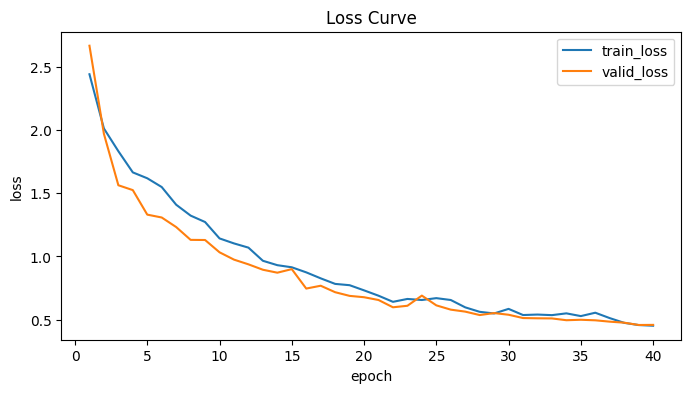

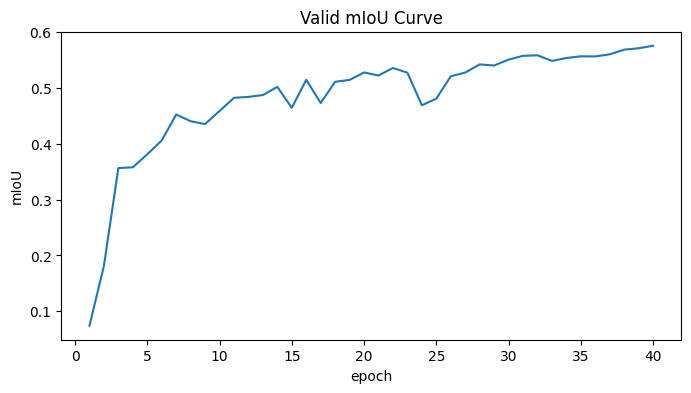

In [49]:
# [Code Cell] 9-5. 학습 로그 확인(표) + 간단 그래프
import pandas as pd
import matplotlib.pyplot as plt

df_hist = pd.read_csv(log_csv_path)
display(df_hist.tail(10))

plt.figure(figsize=(8, 4))
plt.plot(df_hist["epoch"], df_hist["train_loss"])
plt.plot(df_hist["epoch"], df_hist["valid_loss"])
plt.title("Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train_loss", "valid_loss"])
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_hist["epoch"], df_hist["valid_miou"])
plt.title("Valid mIoU Curve")
plt.xlabel("epoch")
plt.ylabel("mIoU")
plt.show()

## 10. Test 평가 및 예측 시각화(정량/정성) 결과 저장

이 단계에서는 **best checkpoint**를 로드하여 test set에서 최종 성능을 평가한다.

- 정량 평가(Quantitative)
  - test loss, mIoU, mean Dice 계산
  - 클래스별 IoU 표 저장

- 정성 평가(Qualitative)
  - GT vs Pred 컬러 마스크/오버레이 시각화를 저장해
    경계 깨짐/누락/섞임 같은 오류를 확인한다.

> 세그멘테이션은 숫자만으로 놓치는 오류가 있어, 표 + 시각화를 함께 남기는 것이 설득력이 크다.

In [50]:
# [Code Cell] 10-1. best checkpoint 로드 + test loader 준비 확인

from pathlib import Path
import torch
import json
import numpy as np

try:
    model, device, test_loader, RUN_DIR
except NameError:
    raise RuntimeError("7~9번(모델/loader/학습)까지 먼저 실행해 주세요.")

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

# 1) 9-1에서 best_path 변수를 이미 만들어뒀으면 우선 사용
best_path_candidate = globals().get("best_path", None)
if best_path_candidate is not None and Path(best_path_candidate).exists():
    best_path = Path(best_path_candidate)
else:
    # 2) 없으면 GEN_ROOT 기준 표준 위치로 탐색
    best_path = GEN_ROOT / "ckpts" / RUN_NAME / "best_miou.pt"

assert best_path.exists(), f"[ERROR] best checkpoint가 없습니다: {best_path}"

ckpt = torch.load(best_path, map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

print("[OK] Loaded best checkpoint:", best_path)
print(" - ckpt epoch :", ckpt.get("epoch"))
print(" - best metric:", ckpt.get("metrics", {}))

[OK] Loaded best checkpoint: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\ckpts\run_20260126_104626\best_miou.pt
 - ckpt epoch : 40
 - best metric: {'epoch': 40, 'lr': 7.5e-05, 'train_loss': 0.45194673703776467, 'train_ce': 0.24702809668249553, 'train_dice_loss': 0.4098372790548537, 'valid_loss': 0.45859065651893616, 'valid_ce': 0.21938546374440193, 'valid_dice_loss': 0.47841039299964905, 'valid_miou': 0.5750321745872498, 'valid_mean_dice': 0.6142730214277263, 'time_sec': 3.0093984603881836}


In [51]:
# [Code Cell] 10-2. Test 전체 평가: loss / mIoU / mean Dice + 클래스별 IoU 계산
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import json

@torch.no_grad()
def evaluate_with_cm_and_loss(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_ce = 0.0
    total_dl = 0.0
    n_batches = 0

    cm_total = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=device)
    dice_list = []

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["mask"].to(device, non_blocking=True)

        logits = model(x)
        loss, parts = combined_loss(logits, y, lam_dice=LAMBDA_DICE)

        total_loss += loss.item()
        total_ce += parts["ce"]
        total_dl += parts["dice"]
        n_batches += 1

        pred = torch.argmax(logits, dim=1)
        cm = compute_confusion_matrix(pred, y, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL)
        cm_total += cm
        dice_list.append(compute_mean_dice(pred, y, num_classes=NUM_CLASSES, ignore_index=IGNORE_LABEL))

    miou, iou_per_class = compute_miou_from_cm(cm_total)
    mean_dice = float(np.mean(dice_list)) if len(dice_list) else 0.0

    gt_pixel_per_class = cm_total.sum(dim=1).detach().cpu().numpy().tolist()  # row sum

    return {
        "loss": total_loss / max(n_batches, 1),
        "ce": total_ce / max(n_batches, 1),
        "dice_loss": total_dl / max(n_batches, 1),
        "miou": miou,
        "mean_dice": mean_dice,
        "cm_total": cm_total.detach().cpu(),
        "iou_per_class": iou_per_class,
        "gt_pixel_per_class": gt_pixel_per_class,
    }

# RUN_DIR 기반 경로 통일
RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

test_result = evaluate_with_cm_and_loss(model, test_loader, device)

print("[TEST RESULT]")
print(" - test_loss :", test_result["loss"])
print(" - test_ce   :", test_result["ce"])
print(" - test_dice_loss:", test_result["dice_loss"])
print(" - test_mIoU :", test_result["miou"])
print(" - test_mean_dice:", test_result["mean_dice"])

# class mapping 로드(이름)
map_path = RUN_DIR / "class_mapping.json"
with open(map_path, "r", encoding="utf-8") as f:
    class_map = json.load(f)
tid2name = {int(k): v for k, v in class_map["train_id_to_name"].items()}

rows = []
for tid in range(NUM_CLASSES):
    gt_pix = int(test_result["gt_pixel_per_class"][tid])
    iou = float(test_result["iou_per_class"][tid])
    rows.append({
        "train_id": tid,
        "class_name": tid2name.get(tid, str(tid)),
        "gt_pixel_sum": gt_pix,
        "IoU": (iou if gt_pix > 0 else None),
        "note": ("GT 없음" if gt_pix == 0 else ""),
    })

df_iou = pd.DataFrame(rows)
display(df_iou)

# 저장 경로 통일: GEN_ROOT/eval/RUN_NAME
OUT_DIR = GEN_ROOT / "eval" / RUN_NAME
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_iou_path = OUT_DIR / "test_class_iou.csv"
df_iou.to_csv(df_iou_path, index=False, encoding="utf-8-sig")

# best_path 변수가 없을 수도 있으니 안전 처리
best_path_used = globals().get("best_path", None)
best_path_used = str(best_path_used) if best_path_used is not None else ""

summary_path = OUT_DIR / "test_summary.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump({
        "run_name": RUN_NAME,
        "ckpt_path": best_path_used,
        "test_loss": test_result["loss"],
        "test_ce": test_result["ce"],
        "test_dice_loss": test_result["dice_loss"],
        "test_miou": test_result["miou"],
        "test_mean_dice": test_result["mean_dice"],
    }, f, indent=2, ensure_ascii=False)

print("[OK] Saved:")
print(" -", df_iou_path)
print(" -", summary_path)
print(" - OUT_DIR:", OUT_DIR)

[TEST RESULT]
 - test_loss : 0.4672001227736473
 - test_ce   : 0.23234432935714722
 - test_dice_loss: 0.4697115868330002
 - test_mIoU : 0.587020218372345
 - test_mean_dice: 0.6235090741796683


,train_id,class_name,gt_pixel_sum,IoU,note
0,0,Goal Bar,30553,0.765137,
1,1,Referee,8078,0.000000,
2,2,Advertisement,302095,0.883202,
3,3,Ground,864743,0.973379,
4,4,Ball,1854,0.000000,
5,5,Coaches & Officials,0,NaN,GT 없음
6,6,Audience,616915,0.928415,
7,7,Goalkeeper A,27412,0.638281,
8,8,Goalkeeper B,9334,0.011900,
9,9,Team A,169744,0.812496,


[OK] Saved:
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\eval\run_20260126_104626\test_class_iou.csv
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\eval\run_20260126_104626\test_summary.json
 - OUT_DIR: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\eval\run_20260126_104626


In [52]:
# [Code Cell] 10-3. 예측 시각화 저장(최소 10장): 공용 유틸 호출 버전
from pathlib import Path

try:
    model, test_loader, device, RUN_DIR, CFG, OUT_DIR
except NameError:
    raise RuntimeError("10-2까지 실행되어야 합니다. (model/test_loader/device/RUN_DIR/CFG/OUT_DIR 필요)")

VIS_DIR = Path(OUT_DIR) / "vis"
N_SAVE = int(CFG.get("n_vis_test", 12))

saved, shown = save_pred_vis_grids(
    model=model,
    loader=test_loader,
    device=device,
    run_dir=RUN_DIR,
    out_dir=VIS_DIR,
    n_save=N_SAVE,
    n_show=0,          # 10-3은 파일 저장만
    alpha=0.45,
    prefix="test",
)

print("[OK] Saved visualizations:", saved)
print(" - VIS_DIR:", VIS_DIR)

[OK] Saved visualizations: 12
 - VIS_DIR: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\eval\run_20260126_104626\vis


## 11. Ball-aware Crop 기반 파인튜닝(작은 객체 개선 목적)

테스트에서 **Ball IoU가 0**인 현상을 개선하기 위해, 작은 객체에 더 강한 학습 신호를 주는 파인튜닝을 수행한다.

- 아이디어
  - 공이 포함된 이미지에 한해 **공 주변을 crop → resize** 하여
    입력에서 공의 상대 크기를 키운다.

- 학습 방식
  - baseline best checkpoint에서 시작
  - 낮은 LR로 짧게 파인튜닝
  - Valid mIoU 기준으로 best 저장 후 test 재평가

> 작은 객체는 전체 resize 기반 학습에서 픽셀이 쉽게 소실되므로, “상대 크기 확대”가 현실적인 개선 시도다.

In [53]:
# [Code Cell] 11-1. Ball-aware Dataset 정의(학습 split에만 적용)
import numpy as np
import random
from PIL import Image
import torch
from torch.utils.data import Dataset

BALL_ID = 4
IGNORE_LABEL = 255

class FootballSegDatasetBallCrop(Dataset):
    def __init__(self, df: pd.DataFrame, transforms=None, ball_crop_p=0.7, crop_size=768, seed=42):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.ball_crop_p = float(ball_crop_p)
        self.crop_size = int(crop_size)
        self.rng = random.Random(seed)

    def __len__(self):
        return len(self.df)

    def _crop_around_point(self, img, msk, cy, cx, crop_size):
        h, w = msk.shape
        cs = min(crop_size, h, w)
        y1 = max(0, cy - cs // 2)
        x1 = max(0, cx - cs // 2)
        y2 = y1 + cs
        x2 = x1 + cs
        if y2 > h:
            y2 = h
            y1 = h - cs
        if x2 > w:
            x2 = w
            x1 = w - cs
        img_c = img[y1:y2, x1:x2]
        msk_c = msk[y1:y2, x1:x2]
        return img_c, msk_c

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = str(row["image_path"])
        mask_path = str(row["mask_path"])

        img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)
        msk = np.array(Image.open(mask_path), dtype=np.uint8)

        # Ball-aware crop (학습에서만 사용하므로 이 Dataset은 train용으로만 쓸 예정)
        if self.rng.random() < self.ball_crop_p:
            ys, xs = np.where(msk == BALL_ID)
            if len(ys) > 0:
                j = self.rng.randrange(len(ys))
                cy, cx = int(ys[j]), int(xs[j])
                img, msk = self._crop_around_point(img, msk, cy, cx, self.crop_size)

        if self.transforms is not None:
            out = self.transforms(image=img, mask=msk)
            img = out["image"]
            msk = out["mask"]

        img_t = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        msk_t = torch.from_numpy(msk).long()

        return {
            "image": img_t,
            "mask": msk_t,
            "image_id": int(row["image_id"]),
            "image_path": img_path,
            "mask_path": mask_path,
        }

print("[OK] Ball-aware Dataset ready.")

[OK] Ball-aware Dataset ready.


In [54]:
# [Code Cell] 11-2. Ball-aware train_loader 재구성(Valid/Test는 그대로)
from torch.utils.data import DataLoader
import torch

# 파라미터(필요하면 여기만 조절)
BALL_CROP_P = float(CFG.get("ball_crop_p", 0.7))
BALL_CROP_SIZE = int(CFG.get("ball_crop_size", 768))
BATCH_SIZE = int(CFG.get("batch_size", 4))

train_ds_ball = FootballSegDatasetBallCrop(
    df_train,
    transforms=train_tfms,            # 6번에서 만든 train_tfms 그대로 사용
    ball_crop_p=BALL_CROP_P,
    crop_size=BALL_CROP_SIZE,
    seed=int(CFG.get("seed", 42)),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = True if device.type == "cuda" else False

train_loader_ball = DataLoader(
    train_ds_ball, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pin
)

print("[OK] Ball-aware train_loader ready.")
print(" - ball_crop_p   :", BALL_CROP_P)
print(" - ball_crop_size:", BALL_CROP_SIZE)
print(" - batch_size    :", BATCH_SIZE)

[OK] Ball-aware train_loader ready.
 - ball_crop_p   : 0.7
 - ball_crop_size: 768
 - batch_size    : 4


In [55]:
# [Code Cell] 11-3. Best ckpt 로드 후 낮은 LR로 파인튜닝(early stopping 포함)
import torch
import torch.optim as optim
from pathlib import Path
import pandas as pd
import time
import numpy as np

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

# 체크포인트 로드(10-1에서 best 로드했으면 그대로 model이 best 상태)
best_path = GEN_ROOT / "ckpts" / RUN_NAME / "best_miou.pt"
assert best_path.exists(), f"[ERROR] best ckpt 없음: {best_path}"

ckpt = torch.load(best_path, map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.to(device)

# 파인튜닝 설정
FT_EPOCHS = int(CFG.get("ft_epochs", 15))
FT_LR = float(CFG.get("ft_lr", float(CFG.get("lr", 3e-4)) * 0.1))
FT_WD = float(CFG.get("ft_weight_decay", float(CFG.get("weight_decay", 1e-4))))
FT_PATIENCE = int(CFG.get("ft_patience", 6))

optimizer = optim.AdamW(model.parameters(), lr=FT_LR, weight_decay=FT_WD)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6)

# 저장/로그 경로 통일
CKPT_DIR_FT = GEN_ROOT / "ckpts" / RUN_NAME
LOG_DIR_FT  = GEN_ROOT / "logs"  / RUN_NAME
CKPT_DIR_FT.mkdir(parents=True, exist_ok=True)
LOG_DIR_FT.mkdir(parents=True, exist_ok=True)

best_ft_path = CKPT_DIR_FT / "best_miou_ballcrop_ft.pt"
log_ft_csv = LOG_DIR_FT / "train_log_ballcrop_ft.csv"

print("[FT CONFIG]")
print(" - GEN_ROOT :", GEN_ROOT)
print(" - epochs   :", FT_EPOCHS)
print(" - lr       :", FT_LR)
print(" - wd       :", FT_WD)
print(" - patience :", FT_PATIENCE)
print(" - save best:", best_ft_path)
print(" - log csv  :", log_ft_csv)

history = []
best_miou = -1.0
best_epoch = -1
bad_count = 0

for epoch in range(1, FT_EPOCHS + 1):
    t0 = time.time()
    train_metrics = train_one_epoch(model, train_loader_ball, optimizer, device, lam_dice=LAMBDA_DICE)
    valid_metrics = evaluate(model, valid_loader, device)

    scheduler.step(valid_metrics["valid_miou"])
    lr_now = optimizer.param_groups[0]["lr"]
    dt = time.time() - t0

    row = {
        "epoch": epoch,
        "lr": lr_now,
        **train_metrics,
        "valid_loss": valid_metrics["valid_loss"],
        "valid_miou": valid_metrics["valid_miou"],
        "valid_mean_dice": valid_metrics["valid_mean_dice"],
        "time_sec": dt,
    }
    history.append(row)
    pd.DataFrame(history).to_csv(log_ft_csv, index=False, encoding="utf-8-sig")

    improved = valid_metrics["valid_miou"] > best_miou + 1e-6
    if improved:
        best_miou = valid_metrics["valid_miou"]
        best_epoch = epoch
        bad_count = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "cfg": CFG,
            "metrics": row,
            "note": "ball-aware crop finetune",
        }, best_ft_path)
    else:
        bad_count += 1

    print(f"[FT {epoch:02d}/{FT_EPOCHS}] lr={lr_now:.2e} "
          f"| train_loss={row['train_loss']:.4f} "
          f"| valid_mIoU={row['valid_miou']:.4f} "
          f"| valid_Dice={row['valid_mean_dice']:.4f} "
          f"| bad_count={bad_count}/{FT_PATIENCE} "
          f"| {dt:.1f}s")

    if bad_count >= FT_PATIENCE:
        print("[EARLY STOP] No improvement on valid mIoU.")
        break

print("\n[FT DONE]")
print(" - best_epoch:", best_epoch)
print(" - best_valid_mIoU:", best_miou)
print(" - best_ft_path:", best_ft_path)

[FT CONFIG]
 - GEN_ROOT : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated
 - epochs   : 15
 - lr       : 2.9999999999999997e-05
 - wd       : 0.0001
 - patience : 6
 - save best: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\ckpts\run_20260126_104626\best_miou_ballcrop_ft.pt
 - log csv  : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\logs\run_20260126_104626\train_log_ballcrop_ft.csv
[FT 01/15] lr=3.00e-05 | train_loss=0.5794 | valid_mIoU=0.5644 | valid_Dice=0.6062 | bad_count=0/6 | 3.9s
[FT 02/15] lr=3.00e-05 | train_loss=0.4915 | valid_mIoU=0.5709 | valid_Dice=0.6108 | bad_count=0/6 | 3.5s
[FT 03/15] lr=3.00e-05 | train_loss=0.5665 | valid_mIoU=0.5642 | valid_Dice=0.6083 | bad_count=1/6 | 3.5s
[FT 04/15] lr=3.00e-05 | train_loss=0.4985 | valid_mIoU=0.5705 | valid_Dice=0.6118 | bad_count=2/6 | 3.5s
[FT 05/15] lr=1.50e-05 | train_loss=0.4566 | valid_mIoU=0.5701 | valid_Dice=0.6091 | bad_count=3/6 | 3.7s
[FT 06/15] lr

In [56]:
# [Code Cell] 11-4. 파인튜닝 best로 Test 재평가(특히 Ball IoU 확인)
import torch
from pathlib import Path
import pandas as pd

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

best_ft_path = GEN_ROOT / "ckpts" / RUN_NAME / "best_miou_ballcrop_ft.pt"
assert best_ft_path.exists(), f"[ERROR] ft best ckpt 없음: {best_ft_path}"

ckpt_ft = torch.load(best_ft_path, map_location="cpu")
model.load_state_dict(ckpt_ft["model_state"])
model.to(device)
model.eval()

test_result_ft = evaluate_with_cm_and_loss(model, test_loader, device)

print("[TEST RESULT - FT]")
print(" - test_loss :", test_result_ft["loss"])
print(" - test_mIoU :", test_result_ft["miou"])
print(" - test_mean_dice:", test_result_ft["mean_dice"])

rows = []
for tid in range(NUM_CLASSES):
    gt_pix = int(test_result_ft["gt_pixel_per_class"][tid])
    iou = float(test_result_ft["iou_per_class"][tid])
    rows.append({
        "train_id": tid,
        "class_name": tid2name.get(tid, str(tid)),
        "gt_pixel_sum": gt_pix,
        "IoU": (iou if gt_pix > 0 else None),
        "note": ("GT 없음" if gt_pix == 0 else ""),
    })

df_iou_ft = pd.DataFrame(rows)
display(df_iou_ft)

ball_row = df_iou_ft[df_iou_ft["train_id"] == BALL_ID].iloc[0].to_dict()
print("[BALL CHECK]", ball_row)

[TEST RESULT - FT]
 - test_loss : 0.45268387347459793
 - test_mIoU : 0.5944392085075378
 - test_mean_dice: 0.6296479176555665


,train_id,class_name,gt_pixel_sum,IoU,note
0,0,Goal Bar,30553,0.800920,
1,1,Referee,8078,0.000000,
2,2,Advertisement,302095,0.892674,
3,3,Ground,864743,0.974264,
4,4,Ball,1854,0.000000,
5,5,Coaches & Officials,0,NaN,GT 없음
6,6,Audience,616915,0.932342,
7,7,Goalkeeper A,27412,0.640062,
8,8,Goalkeeper B,9334,0.029299,
9,9,Team A,169744,0.813835,


[BALL CHECK] {'train_id': 4, 'class_name': 'Ball', 'gt_pixel_sum': 1854, 'IoU': 0.0, 'note': ''}


## 12. 최종 제출용 결과 Export(FT 모델 기준) + 노트북 출력 정리

이 단계에서는 최종 제출 모델(FT)을 기준으로 결과를 다시 정리해 저장한다.

- 최종 모델 로드 후 test 재평가
- 클래스별 IoU 표 / 요약 JSON 저장
- 노트북에서도 표와 시각화(grid)를 한눈에 볼 수 있게 출력 정리
- 제출용 결과 파일(csv/json)과 시각화 이미지를 export 폴더로 모아 관리

> 제출물은 “모델 + 재현 가능한 정량 결과 + 시각화 근거”가 같이 있을 때 가장 깔끔하다.

In [57]:
# [Code Cell] 12-1. 최종(FT) 모델 로드 + Export 폴더 준비
from pathlib import Path
import torch
import json
import pandas as pd
import numpy as np

RUN_DIR = Path(RUN_DIR)
RUN_NAME = RUN_DIR.name

# RUN_DIR로부터 generated 루트(GEN_ROOT) 추정
if RUN_DIR.parent.name == "runs":
    GEN_ROOT = RUN_DIR.parent.parent
else:
    GEN_ROOT = RUN_DIR.parent

FT_CKPT_PATH = GEN_ROOT / "ckpts" / RUN_NAME / "best_miou_ballcrop_ft.pt"
assert FT_CKPT_PATH.exists(), f"[ERROR] 최종 FT ckpt가 없습니다: {FT_CKPT_PATH}"

ckpt_ft = torch.load(FT_CKPT_PATH, map_location="cpu")
model.load_state_dict(ckpt_ft["model_state"])
model.to(device)
model.eval()

EXPORT_DIR = GEN_ROOT / "export" / RUN_NAME
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

EXPORT_VIS_DIR = EXPORT_DIR / "vis"
EXPORT_VIS_DIR.mkdir(parents=True, exist_ok=True)

print("[FINAL EXPORT READY]")
print(" - GEN_ROOT  :", GEN_ROOT)
print(" - final_ckpt:", FT_CKPT_PATH)
print(" - export_dir:", EXPORT_DIR)
print(" - export_vis:", EXPORT_VIS_DIR)

[FINAL EXPORT READY]
 - GEN_ROOT  : c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated
 - final_ckpt: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\ckpts\run_20260126_104626\best_miou_ballcrop_ft.pt
 - export_dir: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\export\run_20260126_104626
 - export_vis: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\export\run_20260126_104626\vis


In [58]:
# [Code Cell] 12-2. 최종(FT) 모델 Test 재평가 + 클래스별 IoU 표 출력/저장
import json
import pandas as pd

# class mapping 로드
map_path = Path(RUN_DIR) / "class_mapping.json"
with open(map_path, "r", encoding="utf-8") as f:
    class_map = json.load(f)
tid2name = {int(k): v for k, v in class_map["train_id_to_name"].items()}

# test 평가
test_final = evaluate_with_cm_and_loss(model, test_loader, device)

print("[FINAL TEST RESULT]")
print(" - test_loss :", test_final["loss"])
print(" - test_mIoU :", test_final["miou"])
print(" - test_mean_dice:", test_final["mean_dice"])

rows = []
for tid in range(NUM_CLASSES):
    gt_pix = int(test_final["gt_pixel_per_class"][tid])
    iou = float(test_final["iou_per_class"][tid])
    rows.append({
        "train_id": tid,
        "class_name": tid2name.get(tid, str(tid)),
        "gt_pixel_sum": gt_pix,
        "IoU": (iou if gt_pix > 0 else None),
        "note": ("GT 없음" if gt_pix == 0 else ""),
    })

df_final_iou = pd.DataFrame(rows)

# 노트북 출력(표)
display(df_final_iou)

# 저장(csv/json)
csv_path = EXPORT_DIR / "test_class_iou_final.csv"
df_final_iou.to_csv(csv_path, index=False, encoding="utf-8-sig")

summary_path = EXPORT_DIR / "test_summary_final.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump({
        "run_name": RUN_NAME,
        "final_ckpt": str(FT_CKPT_PATH),
        "test_loss": test_final["loss"],
        "test_miou": test_final["miou"],
        "test_mean_dice": test_final["mean_dice"],
        "ball_iou": (float(test_final["iou_per_class"][4]) if len(test_final["iou_per_class"]) > 4 else None),
        "note": "final submission export (FT model)",
    }, f, indent=2, ensure_ascii=False)

print("[OK] Saved final files:")
print(" -", csv_path)
print(" -", summary_path)

# Ball/Coaches 체크를 노트북에 명확히 출력
ball_row = df_final_iou[df_final_iou["train_id"] == 4].iloc[0].to_dict()
coach_row = df_final_iou[df_final_iou["train_id"] == 5].iloc[0].to_dict()
print("[BALL ROW]", ball_row)
print("[COACHES&OFFICIALS ROW]", coach_row)


[FINAL TEST RESULT]
 - test_loss : 0.45268387347459793
 - test_mIoU : 0.5944392085075378
 - test_mean_dice: 0.6296479176555665


,train_id,class_name,gt_pixel_sum,IoU,note
0,0,Goal Bar,30553,0.800920,
1,1,Referee,8078,0.000000,
2,2,Advertisement,302095,0.892674,
3,3,Ground,864743,0.974264,
4,4,Ball,1854,0.000000,
5,5,Coaches & Officials,0,NaN,GT 없음
6,6,Audience,616915,0.932342,
7,7,Goalkeeper A,27412,0.640062,
8,8,Goalkeeper B,9334,0.029299,
9,9,Team A,169744,0.813835,


[OK] Saved final files:
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\export\run_20260126_104626\test_class_iou_final.csv
 - c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\export\run_20260126_104626\test_summary_final.json
[BALL ROW] {'train_id': 4, 'class_name': 'Ball', 'gt_pixel_sum': 1854, 'IoU': 0.0, 'note': ''}
[COACHES&OFFICIALS ROW] {'train_id': 5, 'class_name': 'Coaches & Officials', 'gt_pixel_sum': 0, 'IoU': nan, 'note': 'GT 없음'}


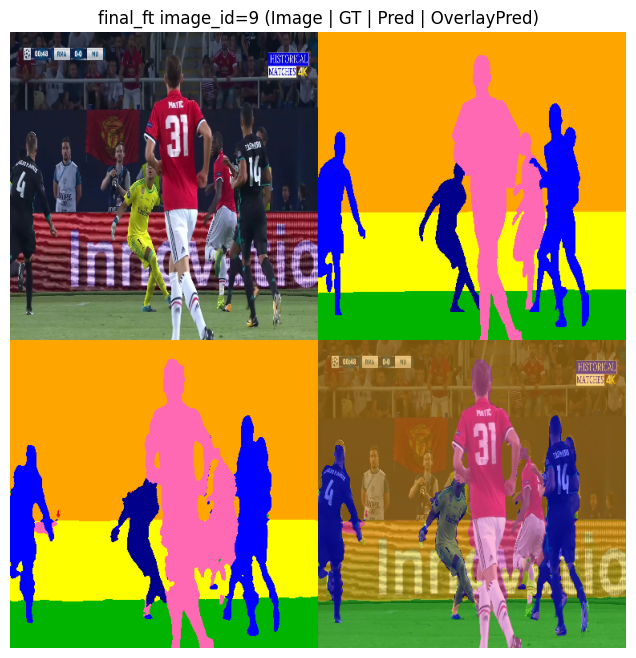

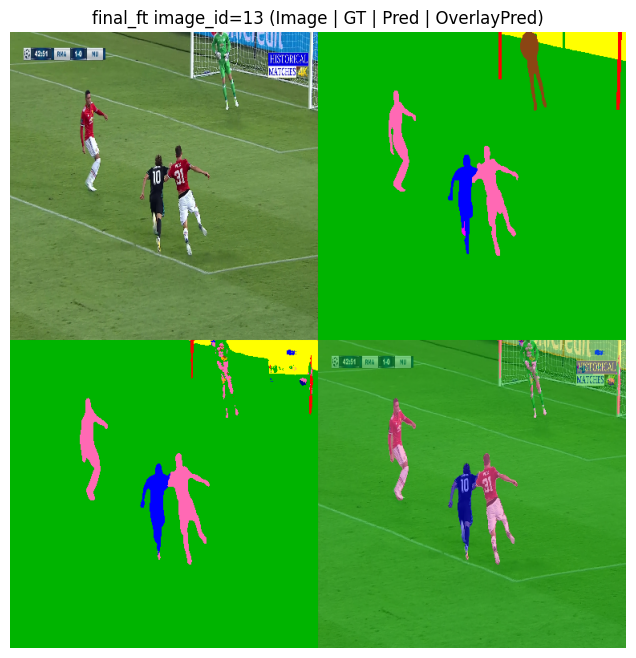

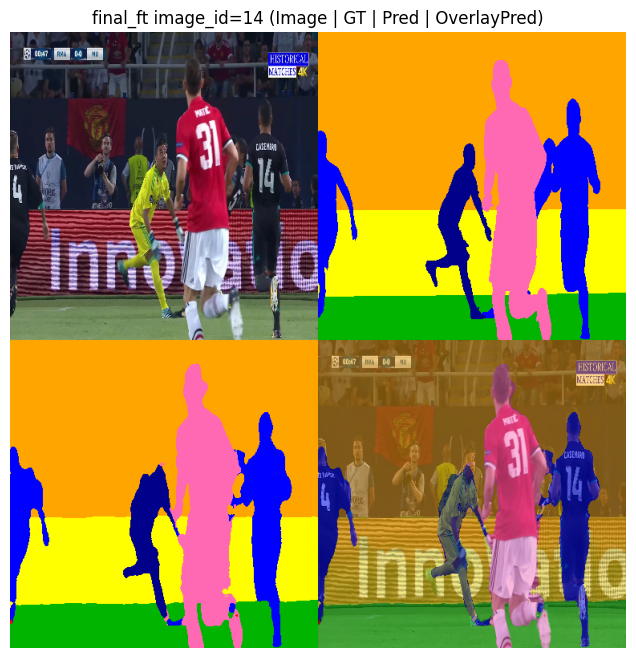

[OK] Saved final visualizations: 12
 - export_vis_dir: c:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\football\generated\export\run_20260126_104626\vis
 - shown in notebook: 3


In [59]:
# [Code Cell] 12-3. 최종(FT) 모델 예측 시각화 생성: 공용 유틸 호출 버전
from pathlib import Path

try:
    model, test_loader, device, RUN_DIR, CFG, EXPORT_VIS_DIR
except NameError:
    raise RuntimeError("12-1까지 실행되어야 합니다. (model/test_loader/device/RUN_DIR/CFG/EXPORT_VIS_DIR 필요)")

N_SAVE = int(CFG.get("n_vis_final", 12))
N_SHOW = int(CFG.get("n_vis_show", 3))

saved, shown = save_pred_vis_grids(
    model=model,
    loader=test_loader,
    device=device,
    run_dir=RUN_DIR,
    out_dir=EXPORT_VIS_DIR,
    n_save=N_SAVE,
    n_show=N_SHOW,     # 12-3은 노트북 출력도 함
    alpha=0.45,
    prefix="final_ft",
)

print("[OK] Saved final visualizations:", saved)
print(" - export_vis_dir:", EXPORT_VIS_DIR)
print(" - shown in notebook:", shown)

# 테스트 결과

## 1) Test 성능 요약 (Baseline vs FT)
본 노트북에서는 baseline(best_miou.pt)과, Ball-aware crop 파인튜닝(FT) 모델을 비교했다.  
(지표: test_loss, mIoU, mean Dice)

| Model | test_loss | test_mIoU | test_mean_dice |
|---|---:|---:|---:|
| Baseline (best_miou.pt) | 0.4672 | 0.5870 | 0.6235 |
| FT (ball-aware crop) | 0.4527 | 0.5944 | 0.6296 |

- **mIoU:** 0.5870 → 0.5944 (소폭 개선)  
- **mean Dice:** 0.6235 → 0.6296 (소폭 개선)

## 2) 클래스 관찰(특히 Ball / Coaches & Officials)
- **Ball**
  - GT 픽셀 합(gt_pixel_sum)=1854로 매우 작은 객체이며,
  - 이번 설정에서는 FT 이후에도 **IoU가 0.0으로 유지**되어 추가 개선이 필요하다.
- **Coaches & Officials**
  - test에서 GT 픽셀 합이 0(=GT 없음)이라 IoU가 NaN으로 기록되며, 평가 해석에서 제외한다.

## 3) 결론(과정 요약)
- COCO 폴리곤 어노테이션을 픽셀 마스크로 생성하고, Train/Valid/Test로 분할해 U-Net 학습 파이프라인을 완성했다.
- CE(ignore_index=255) + Dice 조합으로 학습했고, mIoU/mean Dice로 성능을 평가했다.
- Ball-aware crop FT는 전체 mIoU/mean Dice를 소폭 올렸지만, Ball 클래스 개선은 충분하지 않았다.

## 4) 한계
- **클래스 불균형 / 작은 객체 문제:** Ball처럼 픽셀이 매우 적으면 IoU가 0으로 고정되기 쉽다.
- **데이터 규모 제한:** 100장으로 다양성이 제한되어, 증강/전처리 변경에 결과가 민감할 수 있다.
- **평가 변동성:** 작은 객체는 GT 픽셀 수가 적어 지표가 쉽게 흔들린다.

## 5) 향후 개선 방향
- 작은 객체(Ball) 개선
  - Ball 샘플 **oversampling**, crop 크기/확률 튜닝(더 강하게 “공 중심 확대”)
  - Focal / Tversky / Focal-Tversky loss 등 불균형에 더 강한 손실 실험
  - multi-scale 학습/추론(TTA)로 작은 객체 검출 신호 강화
- 모델/학습 전략
  - 더 강한 encoder(backbone) 적용(ResNet 계열) 또는 Attention U-Net 계열 시도
  - LR warmup + cosine 스케줄, AMP(mixed precision) 등으로 안정적 학습
- 후처리
  - 작은 노이즈 컴포넌트 제거 등 간단한 post-processing으로 정성 품질 개선